# Spiking multicompartment PC network

## Abstract
Predictive coding is a promising theoretical framework for understanding the hierarchical sensory processing in the brain, yet how it is implemented with cortical spiking neurons is still unclear. While most existing works have taken a hand-wiring approach to creating microcircuits which match experimental results, recent work in applying the optimisation approach revealed that cortical connectivity might result from self-organisation given some fundamental computational principle, ie. energy efficiency. We thus investigated whether predictive coding properties in a multicompartment spiking neural network can result from energy optimisation. We found that only the model trained with an energy objective in addition to a task-relevant objective was able to reconstruct internal representations given top-down expectation signals alone. Neurons in the energy-optimised model also showed differential responses to expected vs unexpected stimuli, qualitatively similar to experimental evidence for predictive coding. These findings indicated that predictive-coding-like behaviour might be an emergent property of energy optimisation, providing a new perspective on how predictive coding could be achieved in the cortex.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.parameter import Parameter
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms 
import numpy as np
from datetime import date
import os
import pandas as pd
import math
import shutil


import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# set seed
def set_seeds():
    torch.manual_seed(999)
    torch.cuda.manual_seed(999)
    torch.backends.cudnn.deterministic=True
    np.random.seed(999)


C:\Users\chi6clj\AppData\Local\Temp\ipykernel_18800\3711964913.py:14: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


cuda


In [2]:
## Utils
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def save_checkpoint(state, is_best, prefix, filename='_rec2_bias_checkpoint.pth.tar'):
    print('saving at ', prefix + filename)
    torch.save(state, prefix + filename)
    if is_best:
        shutil.copyfile(prefix + filename, prefix + '_rec2_bias_model_best.pth.tar')


def model_result_dict_load(fn):
    """load tar file with saved model

    Args:
        fn (str): tar file name

    Returns:
        dict: dictornary containing saved results
    """
    with open(fn, 'rb') as f:
        dict = torch.load(f)
    return dict

def save_model(model_name,model):
    torch.save(model,".\\{}_model.pth".format(model_name))
    torch.save(model.state_dict(),".\\{}_state_dict.pth".format(model_name))

def load_model(model_name):
    model=torch.load(".\\{}_model.pth".format(model_name))
    return model

## Import dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 200

traindata = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)

testdata = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)

# data loading
train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size,
                                           shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                          shuffle=False, num_workers=2)


## Surrogate gradient


In [4]:

b_j0 = 0.1  # neural threshold baseline

R_m = 3  # membrane resistance
gamma = .5  # gradient scale
lens = 0.5


def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma


class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        scale = 6.0
        hight = .15
        # temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
        temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
               - gaussian(input, mu=lens, sigma=scale * lens) * hight \
               - gaussian(input, mu=-lens, sigma=scale * lens) * hight
        # temp =  gaussian(input, mu=0., sigma=lens)
        return grad_input * temp.float() * gamma
        # return grad_input


act_fun_adp = ActFun_adp.apply

## Network layers

In [5]:
# layers
def shifted_sigmoid(currents):
    return (1 / (1 + torch.exp(-currents)) - 0.5)/2


class SnnLayer(nn.Module):
    def __init__(
            self,
            in_dim: int,
            hidden_dim: int,
            is_rec: bool,
            is_adapt: bool,
            one_to_one: bool,
            tau_m_init=15.,
            tau_adap_init=20,
            tau_a_init=15.,
            dt = 0.5,
            bias = True
    ):
        super(SnnLayer, self).__init__()

        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.is_rec = is_rec
        self.is_adapt = is_adapt
        self.one_to_one = one_to_one
        self.dt = dt

        if is_rec:
            self.rec_w = nn.Linear(hidden_dim, hidden_dim, bias=bias)
            # init weights
            if bias:
                nn.init.constant_(self.rec_w.bias, 0)
            nn.init.xavier_uniform_(self.rec_w.weight)

            p = torch.full(self.rec_w.weight.size(), fill_value=0.5).to(device)
            self.weight_mask = torch.bernoulli(p)

        else:
            self.fc_weights = nn.Linear(in_dim, hidden_dim, bias=bias)
            if bias:
                nn.init.constant_(self.fc_weights.bias, 0)
            nn.init.xavier_uniform_(self.fc_weights.weight)

        # define param for time constants
        self.tau_adp = nn.Parameter(torch.Tensor(hidden_dim))
        self.tau_m = nn.Parameter(torch.Tensor(hidden_dim))
        self.tau_a = nn.Parameter(torch.Tensor(hidden_dim))

        nn.init.normal_(self.tau_adp, tau_adap_init, .1)
        nn.init.normal_(self.tau_m, tau_m_init, .1)
        nn.init.normal_(self.tau_a, tau_a_init, .1)

        # self.tau_adp = nn.Parameter(torch.Tensor(1))
        # self.tau_m = nn.Parameter(torch.Tensor(1))
        # self.tau_a = nn.Parameter(torch.Tensor(1))

        # nn.init.constant_(self.tau_adp, tau_adap_init)
        # nn.init.constant_(self.tau_m, tau_m_init)
        # nn.init.constant_(self.tau_a, tau_a_init)

        # nn.init.normal_(self.tau_adp, 200., 20.)
        # nn.init.normal_(self.tau_m, 20., .5)

        self.sigmoid = nn.Sigmoid()

    def mem_update(self, ff, fb, soma, spike, a_curr, b, is_adapt, baseline_thre=b_j0, r_m=3):
        """
        mem update for each layer of neurons
        :param ff: feedforward signal
        :param fb: feedback signal to apical tuft
        :param soma: mem voltage potential at soma
        :param spike: spiking at last time step
        :param a_curr: apical tuft current at last t
        :param current: input current at last t
        :param b: adaptive threshold
        :return:
        """
        # alpha = self.sigmoid(self.tau_m)
        # rho = self.sigmoid(self.tau_adp)
        # eta = self.sigmoid(self.tau_a)
        alpha = torch.exp(-self.dt/self.tau_m)
        rho = torch.exp(-self.dt/self.tau_adp)
        eta = torch.exp(-self.dt/self.tau_a)

        if is_adapt:
            beta = 1.8
        else:
            beta = 0.

        b = rho * b + (1 - rho) * spike  # adaptive contribution
        new_thre = baseline_thre + beta * b  # udpated threshold
        
        current_new = ff 

        a_new = eta * a_curr + fb  # fb into apical tuft

        #print("mem update",current_decay , current_curr , ff, eta , a_curr , fb)
        
        soma_new = alpha * soma + shifted_sigmoid(a_new) + current_new - new_thre * spike
        # soma_new = alpha * soma + shifted_sigmoid(a_new) + rise * ff - new_thre * spike
        # soma_new = alpha * soma + 1/2 * (a_new) + ffs - new_thre * spike

        inputs_ = soma_new - new_thre

        spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
        # mem = (1 - spike) * mem

        return soma_new, spike, a_new, new_thre, b

    def forward(self, ff, fb, soma_t, spk_t, a_curr_t, b_t):
        """
        forward function of a single layer. given previous neuron states and current input, update neuron states

        :param ff: ff signal (not counting rec)
        :param fb: fb top down signal
        :param soma_t: soma voltage
        :param a_curr_t: apical tuft voltage
        :return:
        """

        if self.is_rec:
            self.rec_w.weight.data = self.rec_w.weight.data * self.weight_mask
            # self.rec_w.weight.data = (self.rec_w.weight.data < 0).float() * self.rec_w.weight.data
            r_in = ff + self.rec_w(spk_t)
        else:
            if self.one_to_one:
                r_in = ff
            else:
                r_in = self.fc_weights(ff)

        soma_t1, spk_t1, a_curr_t1, _, b_t1 = self.mem_update(r_in, fb, soma_t, spk_t, a_curr_t, b_t, self.is_adapt)

        return soma_t1, spk_t1, a_curr_t1, b_t1


class SnnLayerRiseTime(nn.Module):
    def __init__(
            self,
            in_dim: int,
            hidden_dim: int,
            is_rec: bool,
            is_adapt: bool,
            one_to_one: bool,
            tau_m_init=15.,
            tau_curr_decay_init=10.,
            tau_adap_init=20,
            tau_a_init=15.,
            dt = 0.5,
            bias = True
    ):
        super(SnnLayerRiseTime, self).__init__()

        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.is_rec = is_rec
        self.is_adapt = is_adapt
        self.one_to_one = one_to_one
        self.dt = dt

        if is_rec:
            self.rec_w = nn.Linear(hidden_dim, hidden_dim, bias=bias)
            # init weights
            if bias:
                nn.init.constant_(self.rec_w.bias, 0)
            nn.init.xavier_uniform_(self.rec_w.weight)

            p = torch.full(self.rec_w.weight.size(), fill_value=0.5).to(device)
            self.weight_mask = torch.bernoulli(p)

        else:
            self.fc_weights = nn.Linear(in_dim, hidden_dim, bias=bias)
            if bias:
                nn.init.constant_(self.fc_weights.bias, 0)
            nn.init.xavier_uniform_(self.fc_weights.weight)

        # define param for time constants
        self.tau_adp = nn.Parameter(torch.Tensor(hidden_dim))
        self.tau_m = nn.Parameter(torch.Tensor(hidden_dim))
        self.tau_curr_decay = nn.Parameter(torch.Tensor(hidden_dim))
        self.tau_a = nn.Parameter(torch.Tensor(hidden_dim))

        nn.init.normal_(self.tau_adp, tau_adap_init, .1)
        nn.init.normal_(self.tau_m, tau_m_init, .1)
        nn.init.normal_(self.tau_curr_decay, tau_curr_decay_init, .1)
        nn.init.normal_(self.tau_a, tau_a_init, .1)

        # self.tau_adp = nn.Parameter(torch.Tensor(1))
        # self.tau_m = nn.Parameter(torch.Tensor(1))
        # self.tau_a = nn.Parameter(torch.Tensor(1))

        # nn.init.constant_(self.tau_adp, tau_adap_init)
        # nn.init.constant_(self.tau_m, tau_m_init)
        # nn.init.constant_(self.tau_a, tau_a_init)

        # nn.init.normal_(self.tau_adp, 200., 20.)
        # nn.init.normal_(self.tau_m, 20., .5)

        self.sigmoid = nn.Sigmoid()

    def mem_update(self, ff, fb, soma, spike, a_curr, current_curr, b, is_adapt, baseline_thre=b_j0, r_m=3):
        """
        mem update for each layer of neurons
        :param ff: feedforward signal
        :param fb: feedback signal to apical tuft
        :param soma: mem voltage potential at soma
        :param spike: spiking at last time step
        :param a_curr: apical tuft current at last t
        :param current: input current at last t
        :param b: adaptive threshold
        :return:
        """
        # alpha = self.sigmoid(self.tau_m)
        # rho = self.sigmoid(self.tau_adp)
        # eta = self.sigmoid(self.tau_a)
        alpha = torch.exp(-self.dt/self.tau_m)
        current_decay = torch.exp(-self.dt/self.tau_curr_decay)
        rho = torch.exp(-self.dt/self.tau_adp)
        eta = torch.exp(-self.dt/self.tau_a)

        if is_adapt:
            beta = 1.8
        else:
            beta = 0.
                
        b = rho * b + (1 - rho) * spike  # adaptive contribution
        new_thre = baseline_thre + beta * b  # udpated threshold
        
        current_new = current_decay * current_curr + ff

        a_new = eta * a_curr + fb  # fb into apical tuft

        #print("mem update",current_decay , current_curr , ff, eta , a_curr , fb)
        
        soma_new = alpha * soma + shifted_sigmoid(a_new) + current_new - new_thre * spike
        # soma_new = alpha * soma + shifted_sigmoid(a_new) + rise * ff - new_thre * spike
        # soma_new = alpha * soma + 1/2 * (a_new) + ffs - new_thre * spike

        inputs_ = soma_new - new_thre

        spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
        # mem = (1 - spike) * mem

        return soma_new, spike, a_new, current_new, new_thre, b

    def forward(self, ff, fb, soma_t, spk_t, a_curr_t, current_curr_t, b_t):
        """
        forward function of a single layer. given previous neuron states and current input, update neuron states

        :param ff: ff signal (not counting rec)
        :param fb: fb top down signal
        :param soma_t: soma voltage
        :param a_curr_t: apical tuft voltage
        :return:
        """

        if self.is_rec:
            self.rec_w.weight.data = self.rec_w.weight.data * self.weight_mask
            # self.rec_w.weight.data = (self.rec_w.weight.data < 0).float() * self.rec_w.weight.data
            r_in = ff + self.rec_w(spk_t)
        else:
            if self.one_to_one:
                r_in = ff
            else:
                r_in = self.fc_weights(ff)

        soma_t1, spk_t1, a_curr_t1, current_curr_t1, _, b_t1 = self.mem_update(r_in, fb, soma_t, spk_t, a_curr_t, current_curr_t, b_t, self.is_adapt)

        return soma_t1, spk_t1, a_curr_t1, current_curr_t1, b_t1
        
class OutputLayer(nn.Module):
    def __init__(
            self,
            in_dim: int,
            out_dim: int,
            is_fc: bool,
            tau_fixed=None,
            bias = True,
            dt=0.5
    ):
        """
        output layer class
        :param is_fc: whether integrator is fc to r_out in rec or not
        """
        super(OutputLayer, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.is_fc = is_fc
        self.dt = dt

        if is_fc:
            self.fc = nn.Linear(in_dim, out_dim, bias=bias)
            if bias:
                nn.init.constant_(self.fc.bias, 0)
            nn.init.xavier_uniform_(self.fc.weight)

        # tau_m
        if tau_fixed is None:
            self.tau_m = nn.Parameter(torch.Tensor(out_dim))
            nn.init.constant_(self.tau_m, 5)
        else:
            self.tau_m = nn.Parameter(torch.Tensor(out_dim), requires_grad=False)
            nn.init.constant_(self.tau_m, tau_fixed)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x_t, mem_t):
        """
        integrator neuron without spikes
        """
        alpha = torch.exp(-self.dt/self.tau_m)
        # alpha = self.sigmoid(self.tau_m)

        if self.is_fc:
            x_t = self.fc(x_t)
        else:
            x_t = x_t.view(-1, 10, int(self.in_dim / 10)).mean(dim=2)  # sum up population spike

        # d_mem = -soma_t + x_t
        mem = (mem_t + x_t) * alpha
        # mem = alpha * soma_t + (1 - alpha) * x_t
        return mem



## Network class

In [6]:
# 2 hidden layers
class Decorrelation(nn.Module):
    def __init__(self):
        super(Decorrelation, self).__init__()
        self.decorr_matrix_next = None
    
    def forward(self, input, decorr_matrix_prev_batch):
        n=1e-3
        diag = torch.diag_embed(torch.square(input)) # (batch_size,hidden_dim,hidden_dim)

        input = input.reshape(input.shape[0],input.shape[1],1) # (batch_size,hidden_dim,1)
        input = torch.matmul(decorr_matrix_prev_batch, input) # (batch_size,hidden_dim,1)

        mult = torch.matmul(input, torch.transpose(input,1,2)) # (batch_size,hidden_dim,hidden_dim)
        update = torch.mean(mult - diag, dim=0) # (hidden_dim,hidden_dim)
        self.decorr_matrix_next = decorr_matrix_prev_batch - n * torch.matmul(update, decorr_matrix_prev_batch) # (hidden_dim,hidden_dim)

        input = input.reshape(input.shape[0],input.shape[1]) # (batch_size,hidden_dim)
        return input
        
class SnnNetwork(nn.Module):
    def __init__(
            self,
            in_dim: int,
            hidden_dims: list,
            out_dim: int,
            is_adapt: bool,
            one_to_one: bool,
            dp_rate: float,
            is_rec: bool,
            rise_time: bool,
            bias = True
    ):
        super(SnnNetwork, self).__init__()

        self.in_dim = in_dim
        self.hidden_dims = hidden_dims
        self.out_dim = out_dim
        self.is_adapt = is_adapt
        self.one_to_one = one_to_one
        self.is_rec = is_rec
        self.rise_time = rise_time
        self.dp = nn.Dropout(dp_rate)

        if self.rise_time:
            self.layer1 = SnnLayerRiseTime(hidden_dims[0], hidden_dims[0], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)
        else:
            self.layer1 = SnnLayer(hidden_dims[0], hidden_dims[0], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)

        # r in to r out
        self.layer1to2 = nn.Linear(hidden_dims[0], hidden_dims[1], bias=bias)
        nn.init.xavier_uniform_(self.layer1to2.weight)

        # r out to r in
        self.layer2to1 = nn.Linear(hidden_dims[1], hidden_dims[0], bias=bias)
        nn.init.xavier_uniform_(self.layer2to1.weight)

        if self.rise_time:
            self.layer2 = SnnLayerRiseTime(hidden_dims[1], hidden_dims[1], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)
        else:
            self.layer2 = SnnLayer(hidden_dims[1], hidden_dims[1], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)

        self.output_layer = OutputLayer(hidden_dims[1], out_dim, is_fc=True, bias=bias)

        self.out2layer2 = nn.Linear(out_dim, hidden_dims[1], bias=bias)
        nn.init.xavier_uniform_(self.out2layer2.weight)

        if bias:
            nn.init.constant_(self.layer1to2.bias, 0)
            nn.init.constant_(self.layer2to1.bias, 0)
            nn.init.constant_(self.out2layer2.bias, 0)



        self.fr_layer2 = 0
        self.fr_layer1 = 0

        self.error1 = 0
        self.error2 = 0

    def forward(self, x_t, h):
        batch_dim, input_size = x_t.shape

        x_t = x_t.reshape(batch_dim, input_size).float()
        x_t = self.dp(x_t*0.5)
        # poisson
        # x_t = x_t.gt(0.7).float()

        soma_1, spk_1, a_curr_1, b_1 = self.layer1(ff=x_t, fb=self.layer2to1(h[5]), soma_t=h[0], spk_t=h[1],
                                                   a_curr_t=h[2], b_t=h[3])

        self.error1 = a_curr_1 - soma_1

        # use out mem signal as feedback
        soma_2, spk_2, a_curr_2, b_2 = self.layer2(ff=self.layer1to2(spk_1), fb=self.out2layer2(F.normalize(h[-1], dim=1)), soma_t=h[4],
                                                   spk_t=h[5], a_curr_t=h[6], b_t=h[7])

        self.error2 = a_curr_2 - soma_2

        self.fr_layer2 = self.fr_layer2 + spk_2.detach().cpu().numpy().mean()
        self.fr_layer1 = self.fr_layer1 + spk_1.detach().cpu().numpy().mean()

        # read out from r_out neurons
        mem_out = self.output_layer(spk_2, h[-1])

        h = (soma_1, spk_1, a_curr_1, b_1,
             soma_2, spk_2, a_curr_2, b_2,
             mem_out)

        log_softmax = F.log_softmax(mem_out, dim=1)

        return log_softmax, h

    def inference(self, x_t, h, T, bystep=None):
        """
        only called during inference
        :param x_t: input
        :param h: hidden states
        :param T: sequence length
        :param bystep: if true, then x_t is a sequence
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):

            if bystep is None:
                log_softmax, h = self.forward(x_t, h)
            else:
                log_softmax, h = self.forward(x_t[t], h)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h)
            
        return log_softmax_hist, h_hist

    def inference_rise_time(self, x_t, h, T, bystep=None):
        """
        only called during inference
        :param x_t: input
        :param h: hidden states
        :param T: sequence length
        :param bystep: if true, then x_t is a sequence
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):

            if bystep is None:
                log_softmax, h = self.forward_rise_time(x_t, h)
            else:
                log_softmax, h = self.forward_rise_time(x_t[t], h)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h)
            
        return log_softmax_hist, h_hist

    def clamped_generate(self, test_class, zeros, h_clamped, T, clamp_value=0.5, batch=False, noise=None):
        """
        generate representations with mem of read out clamped
        :param test_class: which class is clamped
        :param zeros: input containing zeros, absence of input
        :param h: hidden states
        :param T: sequence length
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):
            if not batch:
                h_clamped[-1][0] = -clamp_value
                h_clamped[-1][0, test_class] = clamp_value
            else:
                h_clamped[-1][:, :] = torch.full(h_clamped[-1].size(), -clamp_value).to(device)
                h_clamped[-1][:, test_class] = clamp_value

            if noise is not None:
                    h_clamped[-1][:] += noise

            # if t==0:
            #     print(h_clamped[-1])

            log_softmax, h_clamped = self.forward(zeros, h_clamped)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h_clamped)

        return log_softmax_hist, h_hist

    def clamped_generate_rise_time(self, test_class, zeros, h_clamped, T, clamp_value=0.5, batch=False, noise=None):
        """
        generate representations with mem of read out clamped
        :param test_class: which class is clamped
        :param zeros: input containing zeros, absence of input
        :param h: hidden states
        :param T: sequence length
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):
            if not batch:
                h_clamped[-1][0] = -clamp_value
                h_clamped[-1][0, test_class] = clamp_value
            else:
                h_clamped[-1][:, :] = torch.full(h_clamped[-1].size(), -clamp_value).to(device)
                h_clamped[-1][:, test_class] = clamp_value

            if noise is not None:
                    h_clamped[-1][:] += noise

            # if t==0:
            #     print(h_clamped[-1])

            log_softmax, h_clamped = self.forward_rise_time(zeros, h_clamped)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h_clamped)

        return log_softmax_hist, h_hist
        
    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        return (
            # r
            weight.new(bsz, self.hidden_dims[0]).uniform_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).fill_(b_j0),
            # p
            weight.new(bsz, self.hidden_dims[1]).uniform_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).fill_(b_j0),
            # layer out
            weight.new(bsz, self.out_dim).zero_(),
            # sum spike
            weight.new(bsz, self.out_dim).zero_(),
        )


# 3 hidden layers

class SnnNetwork3Layer(SnnNetwork):
    def __init__(
            self,
            in_dim: int,
            hidden_dims: list,
            out_dim: int,
            is_adapt: bool,
            one_to_one: bool,
            dp_rate: float,
            is_rec: bool,
            rise_time: bool,
            bias = True
    ):
        super().__init__(in_dim, hidden_dims, out_dim, is_adapt, one_to_one, dp_rate, is_rec, rise_time)

        # decorrelation
        self.decorr_layer_0 = Decorrelation()
        self.decorr_layer_1 = Decorrelation()
        self.decorr_layer_2 = Decorrelation()
        self.decorr_layer_3 = Decorrelation()
        self.decorr_layer_4 = Decorrelation()

        if self.rise_time:
            self.layer3 = SnnLayerRiseTime(hidden_dims[2], hidden_dims[2], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)
        else:
            self.layer3 = SnnLayer(hidden_dims[2], hidden_dims[2], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)
            
        self.layer2to3 = nn.Linear(hidden_dims[1], hidden_dims[2], bias=bias)
        nn.init.xavier_uniform_(self.layer2to3.weight)

        # r out to r in
        self.layer3to2 = nn.Linear(hidden_dims[2], hidden_dims[1], bias=bias)
        nn.init.xavier_uniform_(self.layer3to2.weight)

        self.output_layer = OutputLayer(hidden_dims[2], out_dim, is_fc=True)

        self.out2layer3 = nn.Linear(out_dim, hidden_dims[2], bias=bias)
        nn.init.xavier_uniform_(self.out2layer3.weight)

        self.fr_layer3 = 0

        self.error3 = 0

        self.input_fc = nn.Linear(in_dim, hidden_dims[0], bias=bias)
        nn.init.xavier_uniform_(self.input_fc.weight)

        if bias:
            nn.init.constant_(self.layer2to3.bias, 0)
            nn.init.constant_(self.layer3to2.bias, 0)
            nn.init.constant_(self.out2layer3.bias, 0)
            nn.init.constant_(self.input_fc.bias, 0)
            print('bias set to 0')

    def forward_rise_time(self, x_t, h):
        batch_dim, input_size = x_t.shape

        x_t = x_t.reshape(batch_dim, input_size).float()
        x_t = self.dp(x_t)
        # poisson
        # x_t = x_t.gt(0.7).float()
        x_t = self.input_fc(x_t)

        soma_1, spk_1, a_curr_1, current_curr_1, b_1 = self.layer1(ff=x_t, fb=self.layer2to1(h[6]), soma_t=h[0], spk_t=h[1],
                                                   a_curr_t=h[2], current_curr_t=h[3], b_t=h[4])

        self.error1 = a_curr_1 - soma_1

        # use out mem signal as feedback
        soma_2, spk_2, a_curr_2, current_curr_2, b_2 = self.layer2(ff=self.layer1to2(spk_1), fb=self.layer3to2(h[11]), soma_t=h[5],
                                                   spk_t=h[6], a_curr_t=h[7], current_curr_t=h[8], b_t=h[9])

        self.error2 = a_curr_2 - soma_2

        soma_3, spk_3, a_curr_3, current_curr_3, b_3 = self.layer3(ff=self.layer2to3(spk_2), fb=self.out2layer3(F.normalize(h[-1], dim=1)), soma_t=h[10],
                                                   spk_t=h[11], a_curr_t=h[12], current_curr_t=h[13], b_t=h[14])
        # soma_3, spk_3, a_curr_3, b_3 = self.layer3(ff=self.layer2to3(spk_2), fb=0, soma_t=h[8],
        #                                            spk_t=h[9], a_curr_t=h[10], b_t=h[11])

        self.error3 = a_curr_3 - soma_3

        self.fr_layer3 = self.fr_layer3 + spk_3.detach().cpu().numpy().mean()
        self.fr_layer2 = self.fr_layer2 + spk_2.detach().cpu().numpy().mean()
        self.fr_layer1 = self.fr_layer1 + spk_1.detach().cpu().numpy().mean()

        # read out from r_out neurons
        mem_out = self.output_layer(spk_3, h[-1])

        h = (soma_1, spk_1, a_curr_1, current_curr_1, b_1,
             soma_2, spk_2, a_curr_2, current_curr_2, b_2,
             soma_3, spk_3, a_curr_3, current_curr_3, b_3,
             mem_out)

        log_softmax = F.log_softmax(mem_out, dim=1)

        return log_softmax, h

    def forward(self, x_t, h):
        batch_dim, input_size = x_t.shape

        x_t = x_t.reshape(batch_dim, input_size).float()
        x_t = self.dp(x_t)
        # poisson
        # x_t = x_t.gt(0.7).float()
        x_t = self.input_fc(x_t)

        soma_1, spk_1, a_curr_1, b_1 = self.layer1(ff=x_t, fb=self.layer2to1(h[5]), soma_t=h[0], spk_t=h[1],
                                                   a_curr_t=h[2], b_t=h[3])

        self.error1 = a_curr_1 - soma_1

        # use out mem signal as feedback
        soma_2, spk_2, a_curr_2, b_2 = self.layer2(ff=self.layer1to2(spk_1), fb=self.layer3to2(h[9]), soma_t=h[4],
                                                   spk_t=h[5], a_curr_t=h[6], b_t=h[7])

        self.error2 = a_curr_2 - soma_2

        soma_3, spk_3, a_curr_3, b_3 = self.layer3(ff=self.layer2to3(spk_2), fb=self.out2layer3(F.normalize(h[-1], dim=1)), soma_t=h[8],
                                                   spk_t=h[9], a_curr_t=h[10], b_t=h[11])
        # soma_3, spk_3, a_curr_3, b_3 = self.layer3(ff=self.layer2to3(spk_2), fb=0, soma_t=h[8],
        #                                            spk_t=h[9], a_curr_t=h[10], b_t=h[11])

        self.error3 = a_curr_3 - soma_3

        self.fr_layer3 = self.fr_layer3 + spk_3.detach().cpu().numpy().mean()
        self.fr_layer2 = self.fr_layer2 + spk_2.detach().cpu().numpy().mean()
        self.fr_layer1 = self.fr_layer1 + spk_1.detach().cpu().numpy().mean()

        # read out from r_out neurons
        mem_out = self.output_layer(spk_3, h[-1])

        h = (soma_1, spk_1, a_curr_1, b_1,
             soma_2, spk_2, a_curr_2, b_2,
             soma_3, spk_3, a_curr_3, b_3,
             mem_out)

        log_softmax = F.log_softmax(mem_out, dim=1)

        return log_softmax, h
        
    def forward_decorrelation(self, x_t, h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4):
        batch_dim, input_size = x_t.shape

        x_t = x_t.reshape(batch_dim, input_size).float()
        x_t = self.dp(x_t)

        # poisson
        # x_t = x_t.gt(0.7).float()

        # decorrelate input
        x_t = self.decorr_layer_0(x_t, decorr_matrix_0)
        decorr_matrix_0 = self.decorr_layer_0.decorr_matrix_next.data.clone()
        x_t = self.input_fc(x_t)

        # decorrelate input to L1
        x_t = self.decorr_layer_1(x_t, decorr_matrix_1)
        decorr_matrix_1 = self.decorr_layer_1.decorr_matrix_next.data.clone()
        
        soma_1, spk_1, a_curr_1, b_1 = self.layer1(ff=x_t, fb=self.layer2to1(h[5]), soma_t=h[0], spk_t=h[1],
                                                   a_curr_t=h[2], b_t=h[3])
        self.error1 = a_curr_1 - soma_1

        # decorrelate input to L2
        spk_1 = self.decorr_layer_2(spk_1, decorr_matrix_2)
        decorr_matrix_2 = self.decorr_layer_2.decorr_matrix_next.data.clone()

        # use out mem signal as feedback
        soma_2, spk_2, a_curr_2, b_2 = self.layer2(ff=self.layer1to2(spk_1), fb=self.layer3to2(h[9]), soma_t=h[4],
                                                   spk_t=h[5], a_curr_t=h[6], b_t=h[7])
        self.error2 = a_curr_2 - soma_2

        # decorrelate input to L3
        spk_2 = self.decorr_layer_3(spk_2, decorr_matrix_3)
        decorr_matrix_3 = self.decorr_layer_3.decorr_matrix_next.data.clone()

        soma_3, spk_3, a_curr_3, b_3 = self.layer3(ff=self.layer2to3(spk_2), fb=self.out2layer3(F.normalize(h[-1], dim=1)), soma_t=h[8],
                                                   spk_t=h[9], a_curr_t=h[10], b_t=h[11])
        self.error3 = a_curr_3 - soma_3

        # decorrelate input to output layer
        spk_3 = self.decorr_layer_4(spk_3, decorr_matrix_4)
        decorr_matrix_4 = self.decorr_layer_4.decorr_matrix_next.data.clone()
        
        self.fr_layer3 = self.fr_layer3 + spk_3.detach().cpu().numpy().mean()
        self.fr_layer2 = self.fr_layer2 + spk_2.detach().cpu().numpy().mean()
        self.fr_layer1 = self.fr_layer1 + spk_1.detach().cpu().numpy().mean()

        # read out from r_out neurons
        mem_out = self.output_layer(spk_3, h[-1])

        h = (soma_1, spk_1, a_curr_1, b_1,
             soma_2, spk_2, a_curr_2, b_2,
             soma_3, spk_3, a_curr_3, b_3,
             mem_out)

        log_softmax = F.log_softmax(mem_out, dim=1)
        return log_softmax, h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4

    def inference_decorrelation(self, x_t, h, T, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4, bystep=None):
        """
        only called during inference
        :param x_t: input
        :param h: hidden states
        :param T: sequence length
        :param bystep: if true, then x_t is a sequence
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):

            if bystep is None:
                log_softmax, h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4 = self.forward_decorrelation(x_t, h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4)
            else:
                log_softmax, h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4 = self.forward_decorrelation(x_t[t], h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h)
            
        return log_softmax_hist, h_hist

    def init_hidden_rise_time(self, bsz):
        weight = next(self.parameters()).data

        return (
            # l1
            weight.new(bsz, self.hidden_dims[0]).uniform_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).fill_(b_j0),
            # l2
            weight.new(bsz, self.hidden_dims[1]).uniform_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).fill_(b_j0),
            # l3
            weight.new(bsz, self.hidden_dims[2]).uniform_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).fill_(b_j0),
            # layer out
            weight.new(bsz, self.out_dim).zero_(),
            # sum spike
            weight.new(bsz, self.out_dim).zero_(),
        )

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data

        return (
            # l1
            weight.new(bsz, self.hidden_dims[0]).uniform_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).fill_(b_j0),
            # l2
            weight.new(bsz, self.hidden_dims[1]).uniform_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).fill_(b_j0),
            # l3
            weight.new(bsz, self.hidden_dims[2]).uniform_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).fill_(b_j0),
            # layer out
            weight.new(bsz, self.out_dim).zero_(),
            # sum spike
            weight.new(bsz, self.out_dim).zero_(),
        )
        
    def init_hidden_allzero(self, bsz):
        weight = next(self.parameters()).data
        return (
            # l1
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).fill_(b_j0),
            # l2
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).fill_(b_j0),
            # l3
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).fill_(b_j0),
            # layer out
            weight.new(bsz, self.out_dim).zero_(),
            # sum spike
            weight.new(bsz, self.out_dim).zero_(),
        )

    def clamp_withnoise(self, test_class, zeros, h_clamped, T, noise, index, batch=False, clamp_value=0.5):
        """
        generate representations with mem of read out clamped
        :param test_class: which class is clamped
        :param zeros: input containing zeros, absence of input
        :param h: hidden states
        :param T: sequence length
        :param noise: noise values
        :param index: index in h where noise is added to
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):
            if not batch:
                h_clamped[-1][0] = -clamp_value
                h_clamped[-1][0, test_class] = clamp_value
            else:
                h_clamped[-1][:, :] = torch.full(h_clamped[-1].size(), -clamp_value).to(device)
                h_clamped[-1][:, test_class] = clamp_value

            if noise is not None:
                h_clamped[index][:, :] += noise * h_clamped[index][:, :]

            # if t==0:
            #     print(h_clamped[-1])

            log_softmax, h_clamped = self.forward(zeros, h_clamped)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h_clamped)

        return log_softmax_hist, h_hist



## FTTP

In [7]:
alpha = .2
beta = .5
rho = 0.


# %%
def get_stats_named_params(model):
    named_params = {}
    for name, param in model.named_parameters():
        sm, lm, dm = param.detach().clone(), 0.0 * param.detach().clone(), 0.0 * param.detach().clone()
        named_params[name] = (param, sm, lm, dm)
    return named_params


def post_optimizer_updates(named_params):
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        lm.data.add_(-alpha * (param - sm))
        sm.data.mul_((1.0 - beta))
        sm.data.add_(beta * param - (beta / alpha) * lm)


def get_regularizer_named_params(named_params, _lambda=1.0):
    regularization = torch.zeros([], device=device)
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        regularization += (rho - 1.) * torch.sum(param * lm)
        r_p = _lambda * 0.5 * alpha * torch.sum(torch.square(param - sm))
        regularization += r_p
        # print(name,r_p)
    return regularization


def reset_named_params(named_params):
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        param.data.copy_(sm.data)


def train_fptt(epoch, batch_size, log_interval,
               train_loader, model, named_params,
               time_steps, k_updates, omega, optimizer,
               clf_alpha, energy_alpha, spike_alpha, clip, lr, rise_time):
    train_loss = 0
    total_clf_loss = 0
    total_regularizaton_loss = 0
    total_energy_loss = 0
    total_spike_loss = 0
    correct = 0
    model.train()
    spk3,memout=[],[]
    # for each batch
    for batch_idx, (data, target) in enumerate(train_loader):

        # to device and reshape
        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)

        B = target.size()[0]

        for p in range(time_steps):
            
            if p == 0:
                if rise_time:
                    h = model.init_hidden_rise_time(data.size(0))
                else:
                    h = model.init_hidden(data.size(0))
            elif p % omega == 0:
                h = tuple(v.detach() for v in h)

            if rise_time:
                o, h = model.forward_rise_time(data, h)
            else:
                o, h = model.forward(data, h)
            #print("\n\nbatch",batch_idx)
            #print("\np",p)
            #print("\nh1",h[1],"\nh6",h[6],"\nh11",h[11])
            #print("\nmemout",h[-1])
            #spk3.append(h[11])
            #memout.append(h[-1])

            # wandb.log({
            #         'rec layer adap threshold': h[5].detach().cpu().numpy(),
            #         'rec layer mem potential': h[3].detach().cpu().numpy()
            #     })

            # get prediction
            if p == (time_steps - 1):
                pred = o.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            if p % omega == 0 and p > 0:
                optimizer.zero_grad()

                # classification loss
                #print("k updates",k_updates,F.nll_loss(o, target),"o",o,o.shape,"target",target,target.shape)
                clf_loss = (p + 1) / k_updates * F.nll_loss(o, target)
                # clf_loss = snr*F.cross_entropy(output, target,reduction='none')
                # clf_loss = torch.mean(clf_loss)

                # regularizer loss
                regularizer = get_regularizer_named_params(named_params, _lambda=1.0)

                # mem potential loss take l1 norm / num of neurons /batch size
                if len(model.hidden_dims) == 2:
                    energy = (torch.sum(model.error1 ** 2) + torch.sum(model.error2 ** 2)) / B / sum(model.hidden_dims)
                    spike_loss = (torch.sum(h[1]) + torch.sum(h[5])) / B / sum(model.hidden_dims)
                elif len(model.hidden_dims) == 3:
                    # energy = (torch.sum(model.error1 ** 2) + torch.sum(model.error2 ** 2) + torch.sum(model.error3 ** 2)) / B / sum(model.hidden_dims)
                    energy = (torch.sum(torch.abs(model.error1)) + torch.sum(torch.abs(model.error2)) + torch.sum(torch.abs(model.error3))) / B / sum(model.hidden_dims)
                    spike_loss = (torch.sum(h[1]) + torch.sum(h[5]) + torch.sum(h[9])) / B / sum(model.hidden_dims)


                # overall loss
                #print("Loss", clf_loss, regularizer, energy, spike_loss)
                loss = clf_alpha * clf_loss + regularizer + energy_alpha * energy + spike_alpha * spike_loss

                loss.backward()

                if clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

                optimizer.step()
                post_optimizer_updates(named_params)

                train_loss += loss.item()
                total_clf_loss += clf_loss.item()
                total_regularizaton_loss += regularizer  # .item()
                total_energy_loss += energy.item()
                total_spike_loss += spike_loss.item()


                model.error1 = 0
                model.error2 = 0
                if len(model.hidden_dims) == 3:
                    model.error3 = 0


        if batch_idx > 0 and batch_idx % log_interval == (log_interval - 1):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tenerg: {:.6f}\tlr: {:.6f}\ttrain acc:{:.4f}\tLoss: {:.6f}\
                \tClf: {:.6f}\tReg: {:.6f}\tFr_p: {:.6f}\tFr_r: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), total_energy_loss / log_interval,
                      lr, 100 * correct / (log_interval * B),
                       train_loss / log_interval,
                       total_clf_loss / log_interval, total_regularizaton_loss / log_interval,
                       model.fr_layer2 / time_steps / log_interval,
                       model.fr_layer1 / time_steps / log_interval))


            train_loss = 0
            total_clf_loss = 0
            total_regularizaton_loss = 0
            total_energy_loss = 0
            total_spike_loss = 0
            correct = 0
            # model.network.fr = 0
            model.fr_layer2 = 0
            model.fr_layer1 = 0
            if len(model.hidden_dims) == 3:
                model.fr_layer3 = 0


def train_fptt_decorr(epoch, batch_size, log_interval,
               train_loader, model, named_params,
               time_steps, k_updates, omega, optimizer,
               clf_alpha, energy_alpha, spike_alpha, clip, lr, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4):
    train_loss = 0
    total_clf_loss = 0
    total_regularizaton_loss = 0
    total_energy_loss = 0
    total_spike_loss = 0
    correct = 0
    model.train()

    # for each batch
    for batch_idx, (data, target) in enumerate(train_loader):

        # to device and reshape
        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)

        B = target.size()[0]

        for p in range(time_steps):

            if p == 0:
                h = model.init_hidden(data.size(0))
            elif p % omega == 0:
                h = tuple(v.detach() for v in h)

            o, h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4 = model.forward_decorrelation(data, h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4)
            # wandb.log({
            #         'rec layer adap threshold': h[5].detach().cpu().numpy(),
            #         'rec layer mem potential': h[3].detach().cpu().numpy()
            #     })

            # get prediction
            if p == (time_steps - 1):
                pred = o.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            if p % omega == 0 and p > 0:
                optimizer.zero_grad()

                # classification loss
                clf_loss = (p + 1) / k_updates * F.nll_loss(o, target)
                # clf_loss = snr*F.cross_entropy(output, target,reduction='none')
                # clf_loss = torch.mean(clf_loss)

                # regularizer loss
                regularizer = get_regularizer_named_params(named_params, _lambda=1.0)

                # mem potential loss take l1 norm / num of neurons /batch size
                if len(model.hidden_dims) == 2:
                    energy = (torch.sum(model.error1 ** 2) + torch.sum(model.error2 ** 2)) / B / sum(model.hidden_dims)
                    spike_loss = (torch.sum(h[1]) + torch.sum(h[5])) / B / sum(model.hidden_dims)
                elif len(model.hidden_dims) == 3:
                    # energy = (torch.sum(model.error1 ** 2) + torch.sum(model.error2 ** 2) + torch.sum(model.error3 ** 2)) / B / sum(model.hidden_dims)
                    energy = (torch.sum(torch.abs(model.error1)) + torch.sum(torch.abs(model.error2)) + torch.sum(torch.abs(model.error3))) / B / sum(model.hidden_dims)
                    spike_loss = (torch.sum(h[1]) + torch.sum(h[5]) + torch.sum(h[9])) / B / sum(model.hidden_dims)


                # overall loss
                loss = clf_alpha * clf_loss + regularizer + energy_alpha * energy + spike_alpha * spike_loss

                loss.backward(retain_graph=True)

                if clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

                optimizer.step()
                post_optimizer_updates(named_params)

                train_loss += loss.item()
                total_clf_loss += clf_loss.item()
                total_regularizaton_loss += regularizer  # .item()
                total_energy_loss += energy.item()
                total_spike_loss += spike_loss.item()


                model.error1 = 0
                model.error2 = 0
                if len(model.hidden_dims) == 3:
                    model.error3 = 0


        if batch_idx > 0 and batch_idx % log_interval == (log_interval - 1):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tenerg: {:.6f}\tlr: {:.6f}\ttrain acc:{:.4f}\tLoss: {:.6f}\
                \tClf: {:.6f}\tReg: {:.6f}\tFr_p: {:.6f}\tFr_r: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), total_energy_loss / log_interval,
                      lr, 100 * correct / (log_interval * B),
                       train_loss / log_interval,
                       total_clf_loss / log_interval, total_regularizaton_loss / log_interval,
                       model.fr_layer2 / time_steps / log_interval,
                       model.fr_layer1 / time_steps / log_interval))


            train_loss = 0
            total_clf_loss = 0
            total_regularizaton_loss = 0
            total_energy_loss = 0
            total_spike_loss = 0
            correct = 0
            # model.network.fr = 0
            model.fr_layer2 = 0
            model.fr_layer1 = 0
            if len(model.hidden_dims) == 3:
                model.fr_layer3 = 0

    return decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4




## Test function

In [8]:
# test function
def test(model, test_loader, time_steps):
    model.eval()
    test_loss = 0
    correct = 0
    
    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)

        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden(data.size(0))
            
            log_softmax_outputs, hidden = model.inference(data, hidden, time_steps)

            test_loss += F.nll_loss(log_softmax_outputs[-1], target, reduction='sum').data.item()

            pred = log_softmax_outputs[-1].data.max(1, keepdim=True)[1]

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        torch.cuda.empty_cache()

    # wandb.log({'spike sequence': plot_spiking_sequence(hidden, target)})

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_acc))

    return test_loss, 100. * correct / len(test_loader.dataset)

def test_rise_time(model, test_loader, time_steps):
    model.eval()
    test_loss = 0
    correct = 0
    
    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)

        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden_rise_time(data.size(0))
            
            log_softmax_outputs, hidden = model.inference_rise_time(data, hidden, time_steps)

            test_loss += F.nll_loss(log_softmax_outputs[-1], target, reduction='sum').data.item()

            pred = log_softmax_outputs[-1].data.max(1, keepdim=True)[1]

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        torch.cuda.empty_cache()

    # wandb.log({'spike sequence': plot_spiking_sequence(hidden, target)})

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_acc))

    return test_loss, 100. * correct / len(test_loader.dataset)

# test function
def test_decorrelation(model, test_loader, time_steps, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4):
    model.eval()
    test_loss = 0
    correct = 0
    
    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)

        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden(data.size(0))
            
            log_softmax_outputs, hidden = model.inference_decorrelation(data, hidden, time_steps, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4)

            test_loss += F.nll_loss(log_softmax_outputs[-1], target, reduction='sum').data.item()

            pred = log_softmax_outputs[-1].data.max(1, keepdim=True)[1]

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        torch.cuda.empty_cache()

    # wandb.log({'spike sequence': plot_spiking_sequence(hidden, target)})

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_acc))

    return test_loss, 100. * correct / len(test_loader.dataset)




## Defining the network

In [9]:
# network parameters
adap_neuron = True  # whether use adaptive neuron or not
clf_alpha = 1
energy_alpha = 0.05  # - config.clf_alpha
spike_alpha = 0.  # energy loss on spikes
num_readout = 10
onetoone = True
lr = 1e-3
alg = 'fptt'
dp = 0.4
is_rec = False


# training parameters
T = 100
K = 10  # k_updates is num updates per sequence
omega = int(T / K)  # update frequency
clip = 1.
log_interval = 20
epochs = 35


In [10]:
# set input and t param
IN_dim = 784
hidden_dim = [600, 500, 500]
n_classes = 10
rise_time=True
torch.manual_seed(999)
# define network
model = SnnNetwork3Layer(IN_dim, hidden_dim, n_classes, is_adapt=adap_neuron,
                         one_to_one=onetoone, dp_rate=dp, is_rec=is_rec, rise_time=rise_time)
model.to(device)
print(model)

# define new loss and optimiser
total_params = count_parameters(model)
print('total param count %i' % total_params)

# define optimiser
optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay=0.0001)
# reduce the learning after 20 epochs by a factor of 10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)


bias set to 0
SnnNetwork3Layer(
  (dp): Dropout(p=0.4, inplace=False)
  (layer1): SnnLayerRiseTime(
    (fc_weights): Linear(in_features=600, out_features=600, bias=True)
    (sigmoid): Sigmoid()
  )
  (layer1to2): Linear(in_features=600, out_features=500, bias=True)
  (layer2to1): Linear(in_features=500, out_features=600, bias=True)
  (layer2): SnnLayerRiseTime(
    (fc_weights): Linear(in_features=500, out_features=500, bias=True)
    (sigmoid): Sigmoid()
  )
  (output_layer): OutputLayer(
    (fc): Linear(in_features=500, out_features=10, bias=True)
    (sigmoid): Sigmoid()
  )
  (out2layer2): Linear(in_features=10, out_features=500, bias=True)
  (decorr_layer_0): Decorrelation()
  (decorr_layer_1): Decorrelation()
  (decorr_layer_2): Decorrelation()
  (decorr_layer_3): Decorrelation()
  (decorr_layer_4): Decorrelation()
  (layer3): SnnLayerRiseTime(
    (fc_weights): Linear(in_features=500, out_features=500, bias=True)
    (sigmoid): Sigmoid()
  )
  (layer2to3): Linear(in_features=

## Train & test

In [11]:
# untrained network
test_loss, acc1 = test_rise_time(model, test_loader, T)


Test set: Average loss: 15.3593, Accuracy: 973/10000 (10%)



In [12]:
named_params = get_stats_named_params(model)
all_test_losses = []
all_test_acc = []
best_acc = 20
model_name="rise_time_control_checkpoint_{}"

for epoch in range(epochs):
    train_fptt(epoch, batch_size, log_interval, train_loader,
               model, named_params, T, K, omega, optimizer,
               clf_alpha, energy_alpha, spike_alpha, clip, lr, rise_time)

    reset_named_params(named_params)

    test_loss, test_acc = test_rise_time(model, test_loader, T)

    scheduler.step()

    # Save checkpoint every epoch rather than only at best acc
    '''
    # remember best acc and save checkpoint
    is_best = test_acc > best_acc
    best_acc = max(test_acc, best_acc)
    
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        # 'oracle_state_dict': oracle.state_dict(),
        'best_acc1': best_acc,
        'optimizer': optimizer.state_dict(),
        # 'oracle_optimizer' : oracle_optim.state_dict(),
    }, is_best, prefix='voltage_diff_', filename='best.pth.tar')
    '''
    save_model(model_name.format(epoch+1),model)
    
    all_test_losses.append(test_loss)
    all_test_acc.append(test_acc)

Train Epoch: 0 [3800/60000 (6%)]	energ: 1069.281784	lr: 0.001000	train acc:41.2500	Loss: -113.563852                	Clf: 203.490547	Reg: -370.518341	Fr_p: 1.731319	Fr_r: 1.655896
Train Epoch: 0 [7800/60000 (13%)]	energ: 626.798966	lr: 0.001000	train acc:52.0250	Loss: -178.775268                	Clf: 135.932346	Reg: -346.047546	Fr_p: 0.458266	Fr_r: 0.482572
Train Epoch: 0 [11800/60000 (20%)]	energ: 476.135909	lr: 0.001000	train acc:27.8500	Loss: -113.853734                	Clf: 199.931774	Reg: -337.592316	Fr_p: 0.405826	Fr_r: 0.430774
Train Epoch: 0 [15800/60000 (26%)]	energ: 417.000561	lr: 0.001000	train acc:13.5500	Loss: -134.037449                	Clf: 175.975284	Reg: -330.862732	Fr_p: 0.358463	Fr_r: 0.374149
Train Epoch: 0 [19800/60000 (33%)]	energ: 363.432606	lr: 0.001000	train acc:11.5250	Loss: -162.480427                	Clf: 145.487225	Reg: -326.139252	Fr_p: 0.359094	Fr_r: 0.398994
Train Epoch: 0 [23800/60000 (40%)]	energ: 338.591142	lr: 0.001000	train acc:10.6250	Loss: -155.79

### Save losses and accuracies

In [ ]:
'''
control_all_test_losses = all_test_losses
control_all_test_acc = all_test_acc
np.save('rise_time_control_test_loss.npy',control_all_test_losses)
np.save('rise_time_control_test_acc.npy',control_all_test_acc)
'''
energy_all_test_losses = all_test_losses
energy_all_test_acc = all_test_acc
np.save('rise_time_energy_test_loss.npy',energy_all_test_losses)
np.save('rise_time_energy_test_acc.npy',energy_all_test_acc)


Base:
    control epoch 8  acc 97.11
    energy  epoch 11 acc 97.3
Rise-time:
    control epoch 9  acc 97.04
    energy  epoch 19 acc 96.97

# Analysis

### Load models and accuracies

In [111]:
control_all_test_losses = np.load('rise_time_control_currdecayinit_10\\rise_time_control_test_loss.npy')
control_all_test_acc = np.load('rise_time_control_currdecayinit_10\\rise_time_control_test_acc.npy')
energy_all_test_losses = np.load('rise_time_energy_currdecayinit_10\\rise_time_energy_test_loss.npy')
energy_all_test_acc = np.load('rise_time_energy_currdecayinit_10\\rise_time_energy_test_acc.npy')

In [10]:
#base
control_model = torch.load('base_control\\base_control_checkpoint_8_model.pth')
energy_model = torch.load('base_energy\\base_energy_checkpoint_11_model.pth')
#rise time
control_model = torch.load('rise_time_control_currdecayinit_10_new\\rise_time_control_checkpoint_9_model.pth')
energy_model = torch.load('rise_time_energy_currdecayinit_10_new\\rise_time_control_checkpoint_19_model.pth')

## Control vs. energy models at equal accuracy

## Figure 2

**Figure 2b**

Text(0, 0.5, 'Test loss')

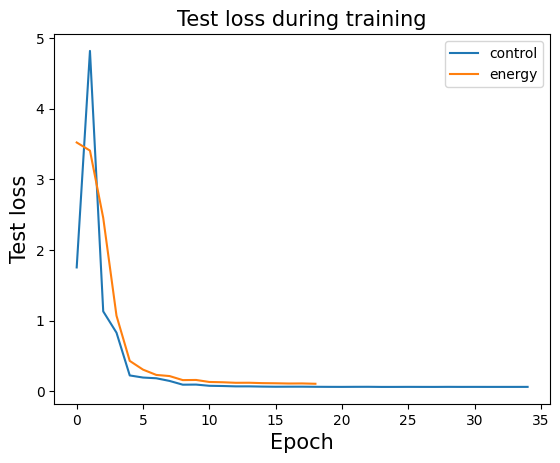

In [11]:
plt.plot(control_all_test_losses,label="control")
plt.plot(energy_all_test_losses,label="energy")
plt.legend()
plt.title('Test loss during training',fontsize=15)
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Test loss',fontsize=15)

Text(0, 0.5, 'Test accuracy (%)')

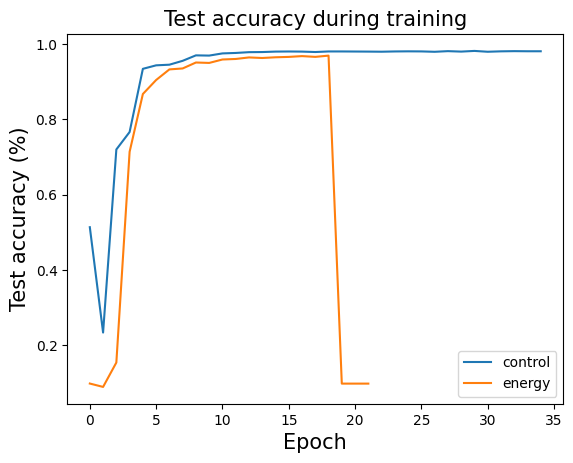

In [12]:
plt.plot(100*np.array(control_all_test_acc)/10000,label="control")
plt.plot(100*np.array(energy_all_test_acc)/10000,label="energy")
plt.legend()
plt.title('Test accuracy during training',fontsize=15)
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Test accuracy (%)',fontsize=15)

Text(0, 0.5, 'Test error rate (%)')

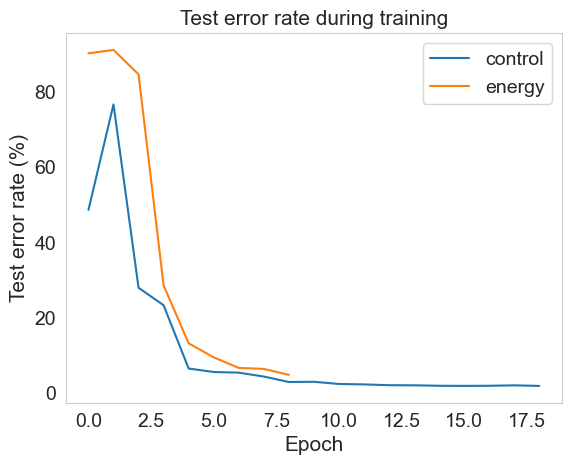

In [116]:
plt.plot(100*(10000-100*np.array(control_all_test_acc[:19]))/10000,label="control")
plt.plot(100*(10000-100*np.array(energy_all_test_acc[:9]))/10000,label="energy")
plt.legend()

plt.title('Test error rate during training',fontsize=15)
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Test error rate (%)',fontsize=15)

**Figure 2c**

In [14]:
# test function
def get_energy(model, test_loader, time_steps):
    model.eval()
    set_seeds()
    spikes1, spikes2, spikes3 = [],[],[]
    errors1,errors2,errors3=[],[],[]
    
    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):

        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)
        
        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden(data.size(0))
            errors_batch1=[]
            errors_batch2=[]
            errors_batch3=[]
            spikes_batch1=[]
            spikes_batch2=[]
            spikes_batch3=[]
            
            #log_softmax_outputs, hidden, errors = model.inference(data, hidden, time_steps)
            for t in range(time_steps):
                log_softmax, hidden = model.forward(data, hidden)

                errors_batch1.append(torch.abs(hidden[0]-hidden[2]).sum())
                errors_batch2.append(torch.abs(hidden[4]-hidden[6]).sum())
                errors_batch3.append(torch.abs(hidden[8]-hidden[10]).sum())
                
                spikes_batch1.append(torch.abs(hidden[1]).sum())
                spikes_batch2.append(torch.abs(hidden[5]).sum())
                spikes_batch3.append(torch.abs(hidden[9]).sum())
                
        errors1.append(torch.stack(errors_batch1))
        errors2.append(torch.stack(errors_batch2))
        errors3.append(torch.stack(errors_batch3))

        spikes1.append(torch.stack(spikes_batch1))
        spikes2.append(torch.stack(spikes_batch1))
        spikes3.append(torch.stack(spikes_batch1))
        
    errors1 = torch.stack(errors1)
    errors2 = torch.stack(errors2)
    errors3 = torch.stack(errors3)
    spikes1 = torch.stack(spikes1)
    spikes2 = torch.stack(spikes2)
    spikes3 = torch.stack(spikes3)
    print("errors shape",errors1.shape)
    #return  spikes1/len(test_loader.dataset)/hidden_dim[0], spikes2/len(test_loader.dataset)/hidden_dim[1], spikes3/len(test_loader.dataset)/hidden_dim[2], torch.sum(energy1/len(test_loader.dataset))/energy1.shape[1], torch.sum(energy2/len(test_loader.dataset))/energy2.shape[1], torch.sum(energy3/len(test_loader.dataset))/energy2.shape[1]
    #return  errors, spikes1/len(test_loader.dataset)/hidden_dim[0], spikes2/len(test_loader.dataset)/hidden_dim[1], spikes3/len(test_loader.dataset)/hidden_dim[2], torch.sum(energy1/len(test_loader.dataset))/energy1.shape[1], torch.sum(energy2/len(test_loader.dataset))/energy2.shape[1], torch.sum(energy3/len(test_loader.dataset))/energy2.shape[1]
    return torch.sum(errors1/len(test_loader.dataset)/hidden_dim[0],axis=0), torch.sum(errors2/len(test_loader.dataset)/hidden_dim[1],axis=0), torch.sum(errors3/len(test_loader.dataset)/hidden_dim[2],axis=0), torch.sum(spikes1)/len(test_loader.dataset)/hidden_dim[0]/time_steps, torch.sum(spikes2)/len(test_loader.dataset)/hidden_dim[1]/time_steps, torch.sum(spikes3)/len(test_loader.dataset)/hidden_dim[2]/time_steps

# test function
def get_energy_rise_time(model, test_loader, time_steps):
    model.eval()
    set_seeds()
    spikes1, spikes2, spikes3 = [],[],[]
    errors1,errors2,errors3=[],[],[]
    
    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):

        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)
        
        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden_rise_time(data.size(0))
            errors_batch1=[]
            errors_batch2=[]
            errors_batch3=[]
            spikes_batch1=[]
            spikes_batch2=[]
            spikes_batch3=[]
            
            #log_softmax_outputs, hidden, errors = model.inference(data, hidden, time_steps)
            for t in range(time_steps):
                log_softmax, hidden = model.forward_rise_time(data, hidden)

                errors_batch1.append(torch.abs(hidden[0]-hidden[2]).sum())
                errors_batch2.append(torch.abs(hidden[5]-hidden[7]).sum())
                errors_batch3.append(torch.abs(hidden[10]-hidden[12]).sum())
                
                spikes_batch1.append(torch.abs(hidden[1]).sum())
                spikes_batch2.append(torch.abs(hidden[6]).sum())
                spikes_batch3.append(torch.abs(hidden[11]).sum())
                
        errors1.append(torch.stack(errors_batch1))
        errors2.append(torch.stack(errors_batch2))
        errors3.append(torch.stack(errors_batch3))

        spikes1.append(torch.stack(spikes_batch1))
        spikes2.append(torch.stack(spikes_batch1))
        spikes3.append(torch.stack(spikes_batch1))
        
    errors1 = torch.stack(errors1)
    errors2 = torch.stack(errors2)
    errors3 = torch.stack(errors3)
    spikes1 = torch.stack(spikes1)
    spikes2 = torch.stack(spikes2)
    spikes3 = torch.stack(spikes3)
    print("errors shape",errors1.shape)
    #return  spikes1/len(test_loader.dataset)/hidden_dim[0], spikes2/len(test_loader.dataset)/hidden_dim[1], spikes3/len(test_loader.dataset)/hidden_dim[2], torch.sum(energy1/len(test_loader.dataset))/energy1.shape[1], torch.sum(energy2/len(test_loader.dataset))/energy2.shape[1], torch.sum(energy3/len(test_loader.dataset))/energy2.shape[1]
    #return  errors, spikes1/len(test_loader.dataset)/hidden_dim[0], spikes2/len(test_loader.dataset)/hidden_dim[1], spikes3/len(test_loader.dataset)/hidden_dim[2], torch.sum(energy1/len(test_loader.dataset))/energy1.shape[1], torch.sum(energy2/len(test_loader.dataset))/energy2.shape[1], torch.sum(energy3/len(test_loader.dataset))/energy2.shape[1]
    return torch.sum(errors1/len(test_loader.dataset)/hidden_dim[0],axis=0), torch.sum(errors2/len(test_loader.dataset)/hidden_dim[1],axis=0), torch.sum(errors3/len(test_loader.dataset)/hidden_dim[2],axis=0), torch.sum(spikes1)/len(test_loader.dataset)/hidden_dim[0]/time_steps, torch.sum(spikes2)/len(test_loader.dataset)/hidden_dim[1]/time_steps, torch.sum(spikes3)/len(test_loader.dataset)/hidden_dim[2]/time_steps



In [17]:
control_energy1, control_energy2, control_energy3, control_spikes1, control_spikes2, control_spikes3 = get_energy_rise_time(control_model, test_loader, T)
energy_energy1, energy_energy2, energy_energy3, energy_spikes1, energy_spikes2, energy_spikes3 = get_energy_rise_time(energy_model, test_loader, T)


errors shape torch.Size([50, 100])
errors shape torch.Size([50, 100])


In [18]:
control_model.layer1

SnnLayerRiseTime(
  (fc_weights): Linear(in_features=600, out_features=600, bias=True)
  (sigmoid): Sigmoid()
)

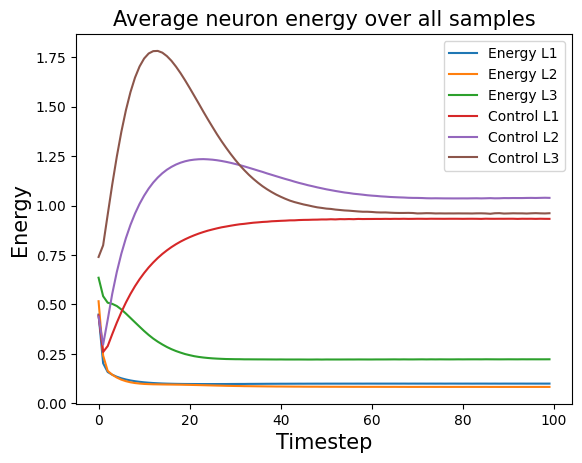

In [19]:
X_axis = np.arange(100)

plt.plot(energy_energy1.cpu().detach().numpy(),label="Energy L1")
plt.plot(energy_energy2.cpu().detach().numpy(),label="Energy L2")
plt.plot(energy_energy3.cpu().detach().numpy(),label="Energy L3")

plt.plot(control_energy1.cpu().detach().numpy(),label="Control L1")
plt.plot(control_energy2.cpu().detach().numpy(),label="Control L2")
plt.plot(control_energy3.cpu().detach().numpy(),label="Control L3")

#plt.xticks(X_axis, labels) 
plt.xlabel("Timestep",fontsize=15) 
plt.ylabel("Energy",fontsize=15) 
plt.title("Average neuron energy over all samples",fontsize=15) 
plt.legend() 
plt.show() 

**Figure 2d**

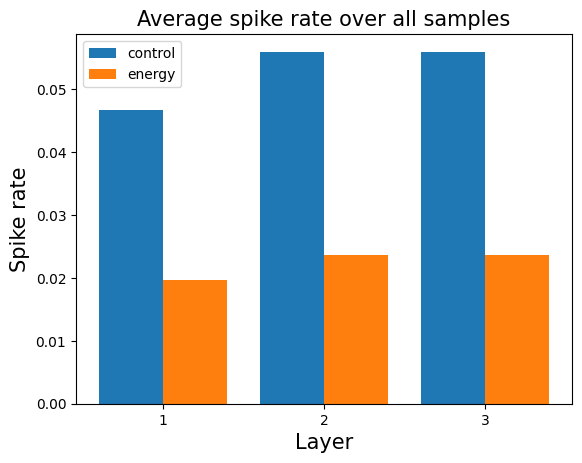

In [20]:
X_axis = np.arange(3)
plt.bar(X_axis-0.2,[control_spikes1.cpu(), control_spikes2.cpu(), control_spikes3.cpu()],0.4,label="control")
plt.bar(X_axis+0.2,[energy_spikes1.cpu(), energy_spikes2.cpu(), energy_spikes3.cpu()],0.4,label="energy")

labels=["1","2","3"]
plt.xticks(X_axis, labels) 
plt.xlabel("Layer",fontsize=15) 
plt.ylabel("Spike rate",fontsize=15) 
plt.title("Average spike rate over all samples",fontsize=15) 
plt.legend() 
plt.show() 

**Figure 2e**

In [21]:
model=control_model

In [22]:
control_mean_weights=[torch.abs(model.layer1to2.weight).mean().cpu().detach().numpy(),torch.abs(model.layer2to1.weight).mean().cpu().detach().numpy(),torch.abs(model.layer2to3.weight).mean().cpu().detach().numpy(),torch.abs(model.layer3to2.weight).mean().cpu().detach().numpy(),torch.abs(model.input_fc.weight).mean().cpu().detach().numpy()]
control_all_weights=(torch.abs(model.layer1to2.weight).sum()+torch.abs(model.layer2to1.weight).sum()+torch.abs(model.layer2to3.weight).sum()+torch.abs(model.layer3to2.weight).sum()+torch.abs(model.input_fc.weight).sum())/(model.layer1to2.weight.flatten().shape[0]+model.layer2to1.weight.flatten().shape[0]+model.layer2to3.weight.flatten().shape[0]+model.layer3to2.weight.flatten().shape[0]+model.input_fc.weight.flatten().shape[0])
control_mean_weights.append(control_all_weights.cpu().detach().numpy())

In [23]:
model=energy_model

In [24]:
energy_mean_weights=[torch.abs(model.layer1to2.weight).mean().cpu().detach().numpy(),torch.abs(model.layer2to1.weight).mean().cpu().detach().numpy(),torch.abs(model.layer2to3.weight).mean().cpu().detach().numpy(),torch.abs(model.layer3to2.weight).mean().cpu().detach().numpy(),torch.abs(model.input_fc.weight).mean().cpu().detach().numpy()]
energy_all_weights=(torch.abs(model.layer1to2.weight).sum()+torch.abs(model.layer2to1.weight).sum()+torch.abs(model.layer2to3.weight).sum()+torch.abs(model.layer3to2.weight).sum()+torch.abs(model.input_fc.weight).sum())/(model.layer1to2.weight.flatten().shape[0]+model.layer2to1.weight.flatten().shape[0]+model.layer2to3.weight.flatten().shape[0]+model.layer3to2.weight.flatten().shape[0]+model.input_fc.weight.flatten().shape[0])
energy_mean_weights.append(control_all_weights.cpu().detach().numpy())

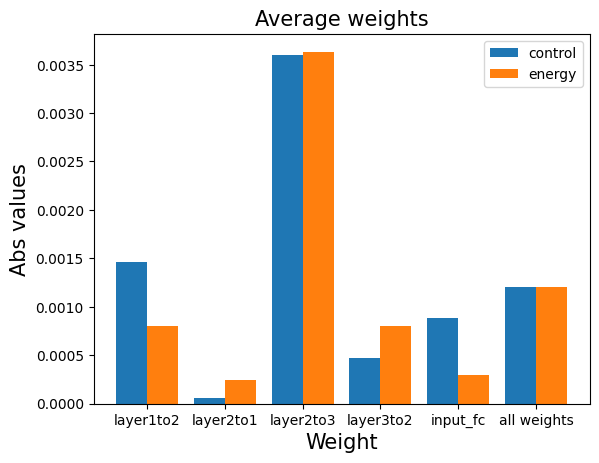

In [25]:
#control_mean_weights=[torch.abs(model.layer1to2.weight).mean().cpu().detach().numpy(),torch.abs(model.layer2to1.weight).mean().cpu().detach().numpy(),torch.abs(model.layer2to3.weight).mean().cpu().detach().numpy(),torch.abs(model.layer3to2.weight).mean().cpu().detach().numpy(),torch.abs(model.input_fc.weight).mean().cpu().detach().numpy()]
#control_all_weights=(torch.abs(model.layer1to2.weight).sum()+torch.abs(model.layer2to1.weight).sum()+torch.abs(model.layer2to3.weight).sum()+torch.abs(model.layer3to2.weight).sum()+torch.abs(model.input_fc.weight).sum())/(model.layer1to2.weight.flatten().shape[0]+model.layer2to1.weight.flatten().shape[0]+model.layer2to3.weight.flatten().shape[0]+model.layer3to2.weight.flatten().shape[0]+model.input_fc.weight.flatten().shape[0])
#control_mean_weights.append(control_all_weights.cpu().detach().numpy())

X_axis = np.arange(6)
plt.bar(X_axis-0.2,control_mean_weights,0.4,label="control")
plt.bar(X_axis+0.2,energy_mean_weights,0.4,label="energy")

#plt.bar(7,control_all_weights.cpu().detach().numpy(),label="control")
#plt.bar(7+0.2,control_all_weights.cpu().detach().numpy(),label="energy")

labels=["layer1to2","layer2to1","layer2to3","layer3to2","input_fc","all weights"]
plt.xticks(X_axis, labels) 
plt.xlabel("Weight",fontsize=15) 
plt.ylabel("Abs values",fontsize=15) 
plt.title("Average weights",fontsize=15) 
plt.legend() 
plt.show() 

## Plotting

In [26]:
def get_states(hiddens_all_: list, idx: int, hidden_dim_: int, batch_size, T=20, num_samples=10000):
    """
    get a particular internal state depending on index passed to hidden
    :param hidden_dim_: the size of a state, eg. num of r or p neurons
    :param T: total time steps
    :param hiddens_all_: list containing hidden states of all batch and time steps during inference
    :param idx: which index in h is taken out
    :return: np array containing desired states
    """
    all_states = []
    for batch_idx in range(len(hiddens_all_)):  # iterate over batch
        batch_ = []
        for t in range(T):
            seq_ = []
            for b in range(batch_size):
                seq_.append(hiddens_all_[batch_idx][t][idx][b].detach().cpu().numpy())
            seq_ = np.stack(seq_)
            batch_.append(seq_)
        batch_ = np.stack(batch_)
        all_states.append(batch_)

    all_states = np.stack(all_states)

    return all_states.transpose(0, 2, 1, 3).reshape(num_samples, T, hidden_dim_)


In [27]:
model.eval()
test_rise_time(model, test_loader, T)


Test set: Average loss: 0.1110, Accuracy: 9680/10000 (97%)



(0.1109640185713768, tensor(96.8000))

In [28]:
# saved_dict = model_result_dict_load('/content/onelayer_rec_best.pth.tar')
# model.load_state_dict(saved_dict['state_dict'])

In [29]:
# get params and put into dict
param_names_wE = []
param_dict_wE = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        param_names_wE.append(name)

print(param_names_wE)

['layer1.tau_adp', 'layer1.tau_m', 'layer1.tau_curr_decay', 'layer1.tau_a', 'layer1.fc_weights.weight', 'layer1.fc_weights.bias', 'layer1to2.weight', 'layer1to2.bias', 'layer2to1.weight', 'layer2to1.bias', 'layer2.tau_adp', 'layer2.tau_m', 'layer2.tau_curr_decay', 'layer2.tau_a', 'layer2.fc_weights.weight', 'layer2.fc_weights.bias', 'output_layer.tau_m', 'output_layer.fc.weight', 'output_layer.fc.bias', 'out2layer2.weight', 'out2layer2.bias', 'layer3.tau_adp', 'layer3.tau_m', 'layer3.tau_curr_decay', 'layer3.tau_a', 'layer3.fc_weights.weight', 'layer3.fc_weights.bias', 'layer2to3.weight', 'layer2to3.bias', 'layer3to2.weight', 'layer3to2.bias', 'out2layer3.weight', 'out2layer3.bias', 'input_fc.weight', 'input_fc.bias']


Text(0.5, 1.0, 'Control model: tau mem decay')

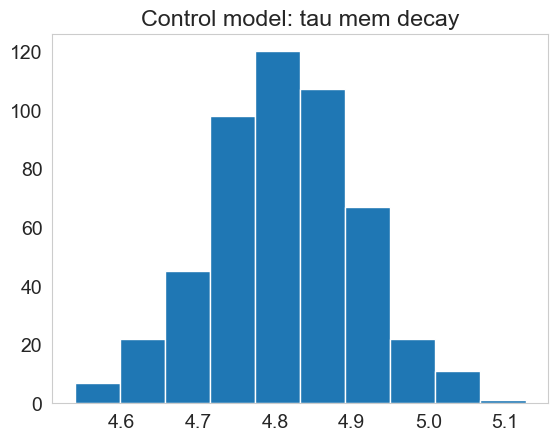

In [133]:
plt.hist(control_model.layer2.tau_m.cpu().detach().numpy())
plt.title('Control model: tau mem decay')

Text(0.5, 1.0, 'Control model: tau current decay')

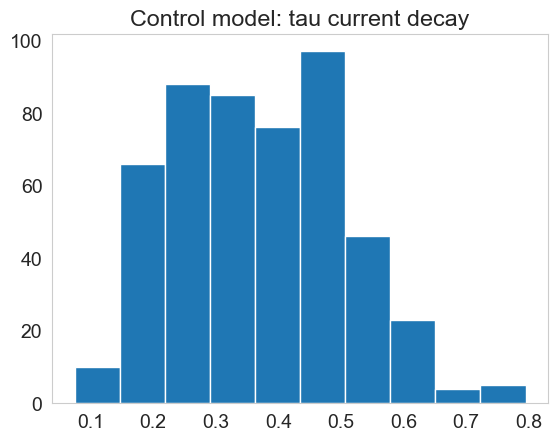

In [132]:
plt.hist(control_model.layer2.tau_curr_decay.cpu().detach().numpy())
plt.title('Control model: tau current decay')

Text(0.5, 1.0, 'Energy model: tau mem decay')

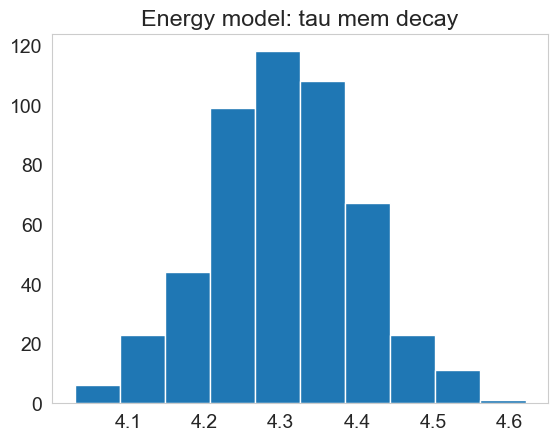

In [134]:
plt.hist(energy_model.layer2.tau_m.cpu().detach().numpy())
plt.title('Energy model: tau mem decay')

Text(0.5, 1.0, 'Energy model: tau current decay')

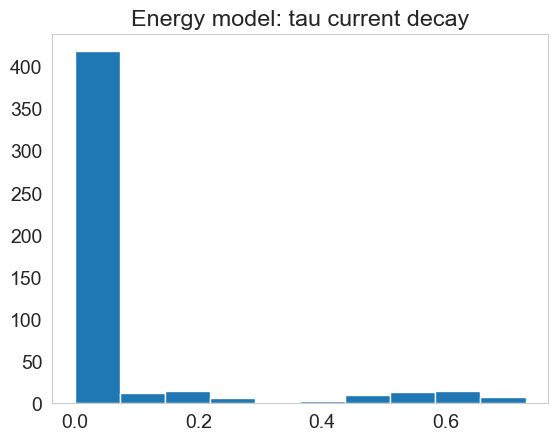

In [135]:
plt.hist(energy_model.layer2.tau_curr_decay.cpu().detach().numpy())
plt.title('Energy model: tau current decay')

Extract internal representations after feeding zeros as input and clamping with different classes
Repeat process but replace zero input with occluded real digit image

In [30]:
def get_clamped_rep(model,occlusion):
    # clamped generation of internal representations     
    
    # if using occluded input instead of no input
    # occlude the top half of the image
    if occlusion:
        test_loader2 = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                                      shuffle=False, num_workers=2)
        for i, (data,target) in enumerate(test_loader2):
            if i==1:
                break
        data[30][0][:14] = -1
        no_input = data[30][0].reshape(1,784).to(device)
    else:
        no_input = torch.zeros((1, IN_dim)).to(device)
    
    clamp_T = T * 5
    
    
    l1_clamp = np.zeros((10, hidden_dim[0]))
    l2_clamp = np.zeros((10, hidden_dim[1]))
    l3_clamp = np.zeros((10, hidden_dim[2]))
    
    
    for i in range(10):
        print(i)
        with torch.no_grad():
            model.eval()
    
            hidden_i = model.init_hidden(1)
    
            _, hidden_gen_E_ = model.clamped_generate(i, no_input, hidden_i, clamp_T, clamp_value=1)
    
            #
            l1 = get_states([hidden_gen_E_], 1, hidden_dim[0], 1, clamp_T, num_samples=1)
            l2 = get_states([hidden_gen_E_], 5, hidden_dim[1], 1, clamp_T, num_samples=1)
            l3 = get_states([hidden_gen_E_], 9, hidden_dim[2], 1, clamp_T, num_samples=1)
    
            l1_clamp[i] += np.squeeze(l1.mean(axis=1))
            l2_clamp[i] += np.squeeze(l2.mean(axis=1))
            l3_clamp[i] += np.squeeze(l3.mean(axis=1))
    
        torch.cuda.empty_cache()
    return l1_clamp, l2_clamp, l3_clamp

def get_clamped_rep_rise_time(model,occlusion):
    # clamped generation of internal representations     
    
    # if using occluded input instead of no input
    # occlude the top half of the image
    if occlusion:
        test_loader2 = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                                      shuffle=False, num_workers=2)
        for i, (data,target) in enumerate(test_loader2):
            if i==1:
                break
        data[30][0][:14] = -1
        no_input = data[30][0].reshape(1,784).to(device)
    else:
        no_input = torch.zeros((1, IN_dim)).to(device)
    
    clamp_T = T * 5
    
    
    l1_clamp = np.zeros((10, hidden_dim[0]))
    l2_clamp = np.zeros((10, hidden_dim[1]))
    l3_clamp = np.zeros((10, hidden_dim[2]))
    
    
    for i in range(10):
        print(i)
        with torch.no_grad():
            model.eval()
    
            hidden_i = model.init_hidden_rise_time(1)
    
            _, hidden_gen_E_ = model.clamped_generate_rise_time(i, no_input, hidden_i, clamp_T, clamp_value=1)
    
            #
            l1 = get_states([hidden_gen_E_], 1, hidden_dim[0], 1, clamp_T, num_samples=1)
            l2 = get_states([hidden_gen_E_], 6, hidden_dim[1], 1, clamp_T, num_samples=1)
            l3 = get_states([hidden_gen_E_], 11, hidden_dim[2], 1, clamp_T, num_samples=1)
    
            l1_clamp[i] += np.squeeze(l1.mean(axis=1))
            l2_clamp[i] += np.squeeze(l2.mean(axis=1))
            l3_clamp[i] += np.squeeze(l3.mean(axis=1))
    
        torch.cuda.empty_cache()
    return l1_clamp, l2_clamp, l3_clamp

In [31]:
# Get clamped representation
# zero_input
control_l1_clamp_E,control_l2_clamp_E,control_l3_clamp_E = get_clamped_rep_rise_time(control_model,occlusion=False)
energy_l1_clamp_E,energy_l2_clamp_E,energy_l3_clamp_E = get_clamped_rep_rise_time(energy_model,occlusion=False)

# occluded input
control_occluded_l1_clamp_E,control_occluded_l2_clamp_E,control_occluded_l3_clamp_E = get_clamped_rep_rise_time(control_model,occlusion=True)
energy_occluded_l1_clamp_E,energy_occluded_l2_clamp_E,energy_occluded_l3_clamp_E = get_clamped_rep_rise_time(energy_model,occlusion=True)

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


Define decoders from internal representation to input

In [32]:
def decode(layer,model):
    set_seeds()
    
    ##############################################################
    # decode from clamped representations
    ##############################################################
    no_input = torch.zeros((1, IN_dim)).to(device)
    
    MSE_loss = nn.MSELoss()
    
    test_loader2 = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    # linear decoder, but change the following class to other decoder types if necessary
    class MLP(nn.Module):
        def __init__(self, in_dim, hidden_dim, out_dim):
            super(MLP, self).__init__()
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.hidden_dim = hidden_dim
    
            self.fc1 = nn.Linear(in_dim, out_dim)
            # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            # self.fc3 = nn.Linear(hidden_dim, out_dim)
    
            # # xavier initialisation
            nn.init.xavier_uniform_(self.fc1.weight)
            # nn.init.xavier_uniform_(self.fc2.weight)
            # nn.init.xavier_uniform_(self.fc3.weight)
    
        def forward(self, x):
            # x = torch.relu(self.fc1(x))
            # x = torch.relu(self.fc2(x))
            x = self.fc1(x)
            return x
    
    # %%
    def plot_projection(rep, label, weights, bias):
        img = (weights @ rep + bias).reshape(28, 28)
        plt.imshow(img)
        plt.title(str(label))
        plt.show()
        return img
    
    def train_linear_proj(layer, model):
        mlp = MLP(hidden_dim[layer], 700, IN_dim).to(device)
        optimiser = optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.0001)
    
        loss_log = []
    
        for e in range(20):
            print(e)
            for i, (data, target) in enumerate(test_loader2):
                data, target = data.to(device), target.to(device)
                data = data.view(-1, model.in_dim)
    
                with torch.no_grad():
                    model.eval()
    
                    hidden = model.init_hidden(data.size(0))
    
                    _, h = model.inference(data, hidden, T)
                    
                spks = get_states([h], 1+layer*4, hidden_dim[layer], batch_size, T, batch_size)
    
                train_data = torch.tensor(spks.mean(axis=1)).to(device)
                # print(train_data.size())
    
                optimiser.zero_grad()
    
                out = mlp(train_data)
                loss = MSE_loss(out, data)
                loss_log.append(loss.data.cpu())
    
                loss.backward()
                optimiser.step()
    
            print('%i train loss: %.4f' % (e, loss))
    
            if e %5 == 0:
                plt.imshow(out[target == 0][0].cpu().detach().reshape(28, 28))
                plt.title('sample1 %i' % target[target == 0][0].item())
                plt.show()
    
                # find the next image with class 0
                # plt.imshow(out[target == 0][1].cpu().detach().reshape(28, 28))
                # plt.title('sample2 %i' % target[target == 0][1].item())
                # plt.show()
    
        torch.cuda.empty_cache()
    
        mlp.eval()
    
        return mlp, [i.cpu() for i in loss_log]
    
    # %%
    #layer = 2
    decoder, loss = train_linear_proj(layer, model)
    
    # %%
    # plot loss curve of training
    colors = [(0.1271049596309112, 0.4401845444059977, 0.7074971164936563),
                         (0.9949711649365629, 0.5974778931180315, 0.15949250288350636)]
    sns.set_style("whitegrid", {'axes.grid' : False})
    
    fig, ax = plt.subplots(figsize=(5, 4))
    plt.rcParams.update({'font.size': 14})
    
    ax.plot(loss, label='Energy L%i' % (layer+1), color=colors[0])
    ax.legend()
    # frame off
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel('MES loss')
    ax.set_xlabel('steps')
    plt.legend(frameon=False)
    # increase font size
    plt.show()
    
    return decoder, loss
    


In [33]:
def decode_rise_time(layer,model):
    set_seeds()
    
    ##############################################################
    # decode from clamped representations
    ##############################################################
    no_input = torch.zeros((1, IN_dim)).to(device)
    
    MSE_loss = nn.MSELoss()
    
    test_loader2 = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    # linear decoder, but change the following class to other decoder types if necessary
    class MLP(nn.Module):
        def __init__(self, in_dim, hidden_dim, out_dim):
            super(MLP, self).__init__()
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.hidden_dim = hidden_dim
    
            self.fc1 = nn.Linear(in_dim, out_dim)
            # self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            # self.fc3 = nn.Linear(hidden_dim, out_dim)
    
            # # xavier initialisation
            nn.init.xavier_uniform_(self.fc1.weight)
            # nn.init.xavier_uniform_(self.fc2.weight)
            # nn.init.xavier_uniform_(self.fc3.weight)
    
        def forward(self, x):
            # x = torch.relu(self.fc1(x))
            # x = torch.relu(self.fc2(x))
            x = self.fc1(x)
            return x
    
    # %%
    def plot_projection(rep, label, weights, bias):
        img = (weights @ rep + bias).reshape(28, 28)
        plt.imshow(img)
        plt.title(str(label))
        plt.show()
        return img
    
    def train_linear_proj(layer, model):
        mlp = MLP(hidden_dim[layer], 700, IN_dim).to(device)
        optimiser = optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.0001)
    
        loss_log = []
    
        for e in range(20):
            print(e)
            for i, (data, target) in enumerate(test_loader2):
                data, target = data.to(device), target.to(device)
                data = data.view(-1, model.in_dim)
    
                with torch.no_grad():
                    model.eval()
    
                    hidden = model.init_hidden_rise_time(data.size(0))
    
                    _, h = model.inference_rise_time(data, hidden, T)
                    
                spks = get_states([h], 1+layer*5, hidden_dim[layer], batch_size, T, batch_size)
    
                train_data = torch.tensor(spks.mean(axis=1)).to(device)
                # print(train_data.size())
    
                optimiser.zero_grad()
    
                out = mlp(train_data)
                loss = MSE_loss(out, data)
                loss_log.append(loss.data.cpu())
    
                loss.backward()
                optimiser.step()
    
            print('%i train loss: %.4f' % (e, loss))
    
            if e %5 == 0:
                plt.imshow(out[target == 0][0].cpu().detach().reshape(28, 28))
                plt.title('sample1 %i' % target[target == 0][0].item())
                plt.show()
    
                # find the next image with class 0
                # plt.imshow(out[target == 0][1].cpu().detach().reshape(28, 28))
                # plt.title('sample2 %i' % target[target == 0][1].item())
                # plt.show()
    
        torch.cuda.empty_cache()
    
        mlp.eval()
    
        return mlp, [i.cpu() for i in loss_log]
    
    # %%
    #layer = 2
    decoder, loss = train_linear_proj(layer, model)
    
    # %%
    # plot loss curve of training
    colors = [(0.1271049596309112, 0.4401845444059977, 0.7074971164936563),
                         (0.9949711649365629, 0.5974778931180315, 0.15949250288350636)]
    sns.set_style("whitegrid", {'axes.grid' : False})
    
    fig, ax = plt.subplots(figsize=(5, 4))
    plt.rcParams.update({'font.size': 14})
    
    ax.plot(loss, label='Energy L%i' % (layer+1), color=colors[0])
    ax.legend()
    # frame off
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_ylabel('MES loss')
    ax.set_xlabel('steps')
    plt.legend(frameon=False)
    # increase font size
    plt.show()
    
    return decoder, loss
    


Train decoders

0
0 train loss: 0.3634


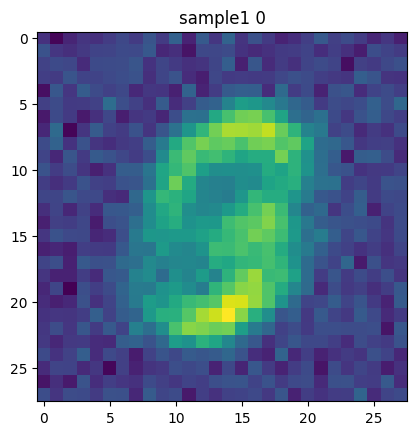

1
1 train loss: 0.2489
2
2 train loss: 0.2229
3
3 train loss: 0.2085
4
4 train loss: 0.1981
5
5 train loss: 0.1906


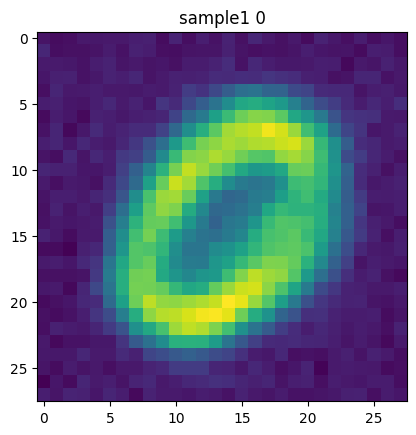

6
6 train loss: 0.1846
7
7 train loss: 0.1798
8
8 train loss: 0.1759
9
9 train loss: 0.1728
10
10 train loss: 0.1702


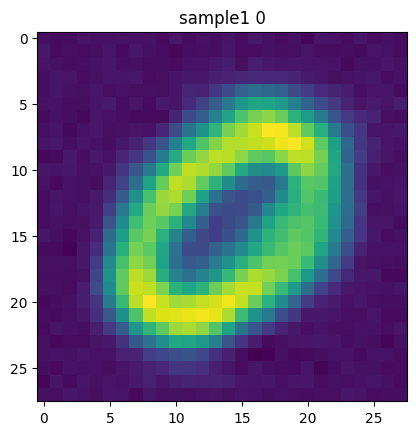

11
11 train loss: 0.1679
12
12 train loss: 0.1660
13
13 train loss: 0.1644
14
14 train loss: 0.1630
15
15 train loss: 0.1618


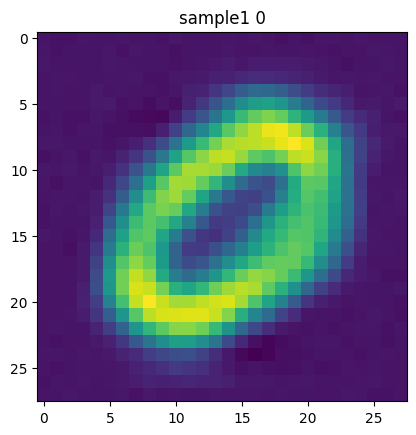

16
16 train loss: 0.1608
17
17 train loss: 0.1598
18
18 train loss: 0.1590
19
19 train loss: 0.1583


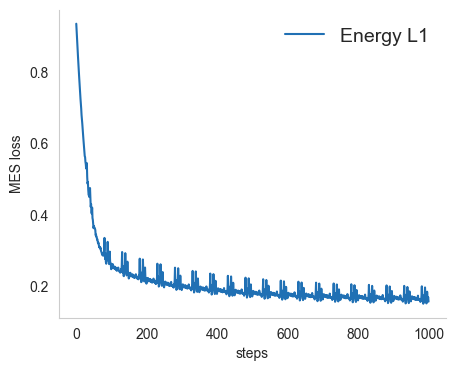

0
0 train loss: 0.2309


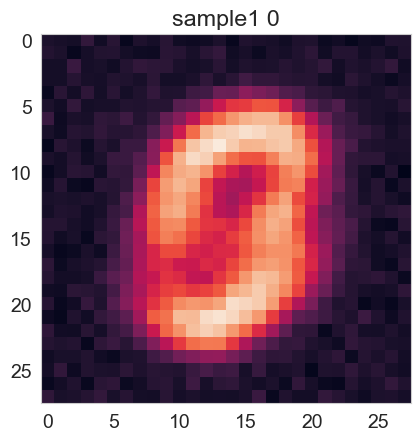

1
1 train loss: 0.2155
2
2 train loss: 0.2065
3
3 train loss: 0.2016
4
4 train loss: 0.1985
5
5 train loss: 0.1965


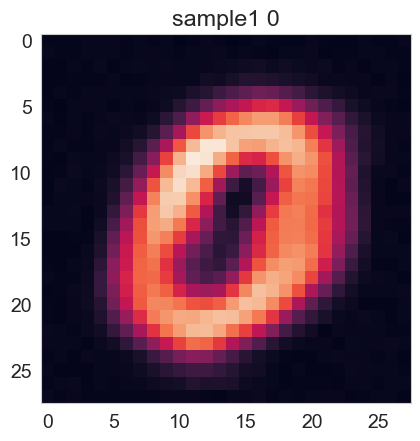

6
6 train loss: 0.1950
7
7 train loss: 0.1938
8
8 train loss: 0.1931
9
9 train loss: 0.1924
10
10 train loss: 0.1918


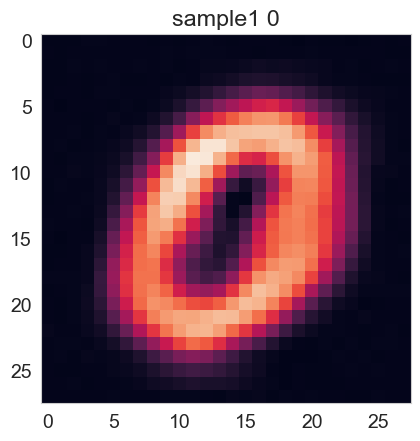

11
11 train loss: 0.1913
12
12 train loss: 0.1909
13
13 train loss: 0.1905
14
14 train loss: 0.1902
15
15 train loss: 0.1899


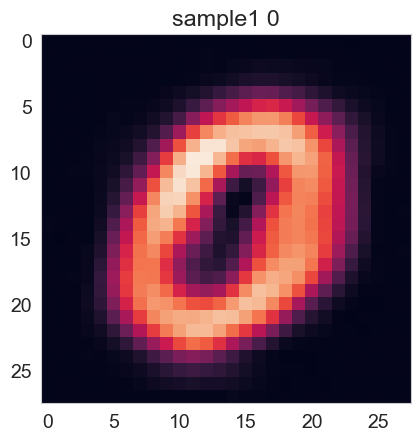

16
16 train loss: 0.1896
17
17 train loss: 0.1895
18
18 train loss: 0.1893
19
19 train loss: 0.1891


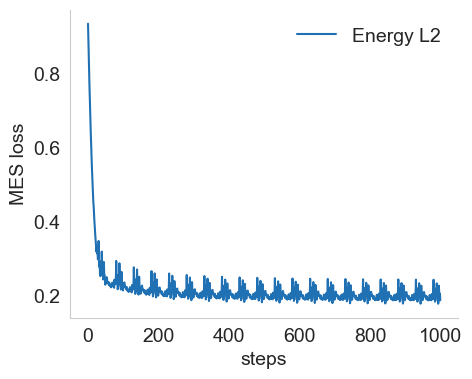

0
0 train loss: 0.2075


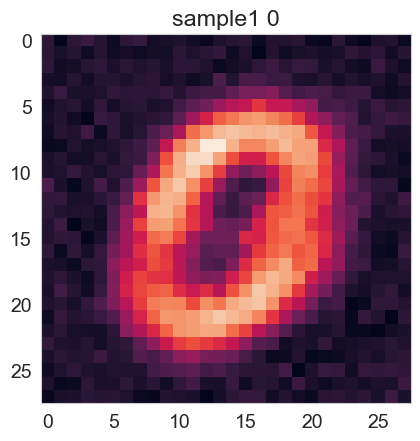

1
1 train loss: 0.1932
2
2 train loss: 0.1892
3
3 train loss: 0.1873
4
4 train loss: 0.1861
5
5 train loss: 0.1852


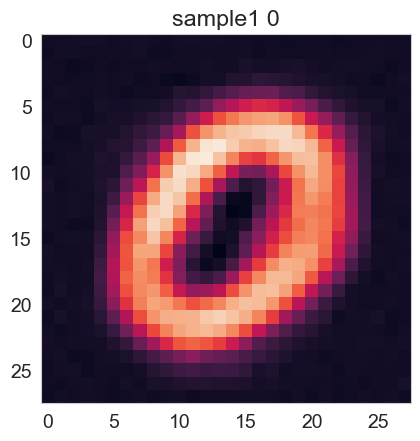

6
6 train loss: 0.1845
7
7 train loss: 0.1840
8
8 train loss: 0.1837
9
9 train loss: 0.1835
10
10 train loss: 0.1832


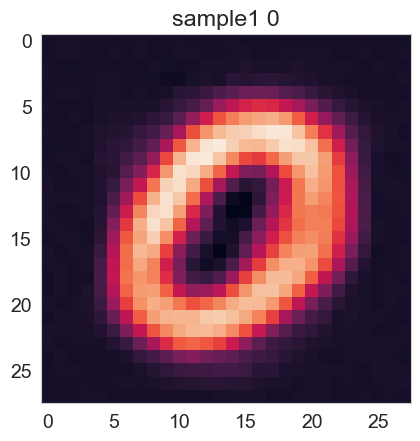

11
11 train loss: 0.1829
12
12 train loss: 0.1827
13
13 train loss: 0.1826
14
14 train loss: 0.1824
15
15 train loss: 0.1824


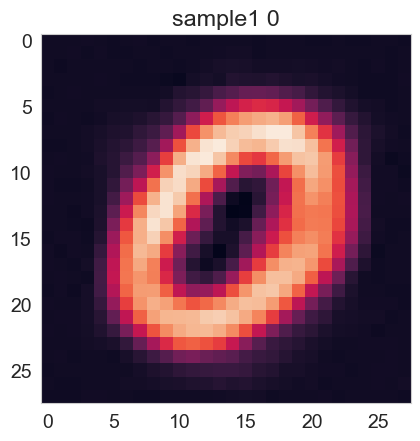

16
16 train loss: 0.1821
17
17 train loss: 0.1822
18
18 train loss: 0.1821
19
19 train loss: 0.1819


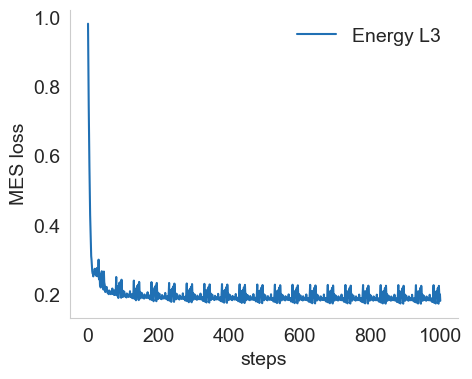

In [34]:
energy_l1_decoder, energy_l1_loss = decode_rise_time(0,energy_model)
energy_l2_decoder, energy_l2_loss = decode_rise_time(1,energy_model)
energy_l3_decoder, energy_l3_loss = decode_rise_time(2,energy_model)

0
0 train loss: 0.1941


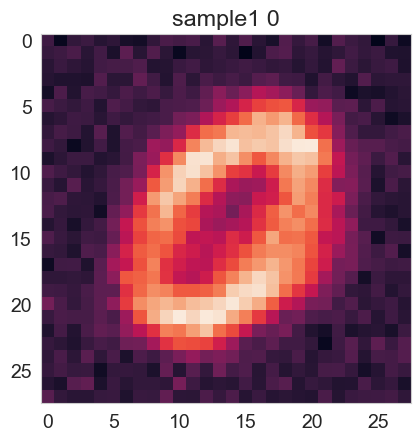

1
1 train loss: 0.1579
2
2 train loss: 0.1415
3
3 train loss: 0.1319
4
4 train loss: 0.1252
5
5 train loss: 0.1201


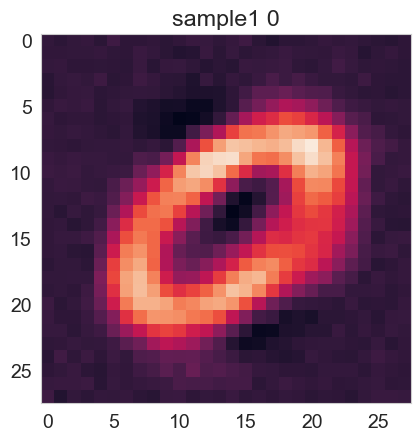

6
6 train loss: 0.1160
7
7 train loss: 0.1127
8
8 train loss: 0.1100
9
9 train loss: 0.1078
10
10 train loss: 0.1060


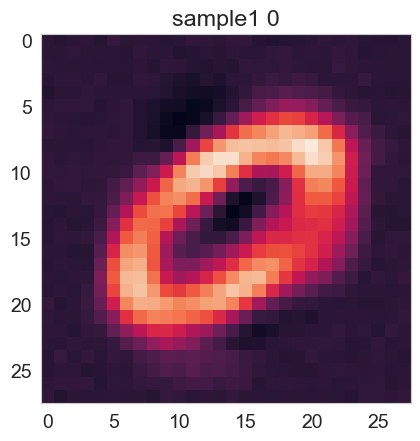

11
11 train loss: 0.1044
12
12 train loss: 0.1030
13
13 train loss: 0.1019
14
14 train loss: 0.1010
15
15 train loss: 0.1002


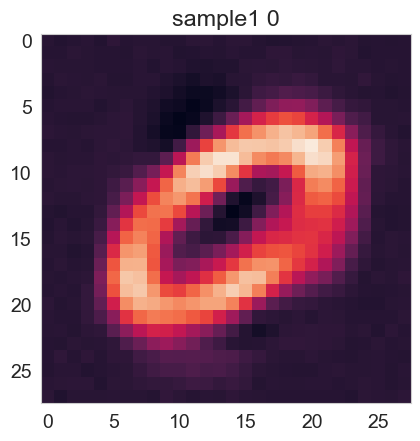

16
16 train loss: 0.0994
17
17 train loss: 0.0988
18
18 train loss: 0.0983
19
19 train loss: 0.0978


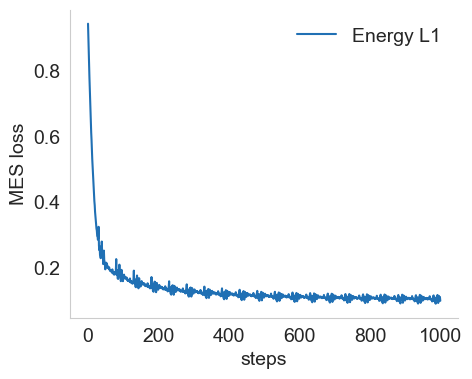

0
0 train loss: 0.2095


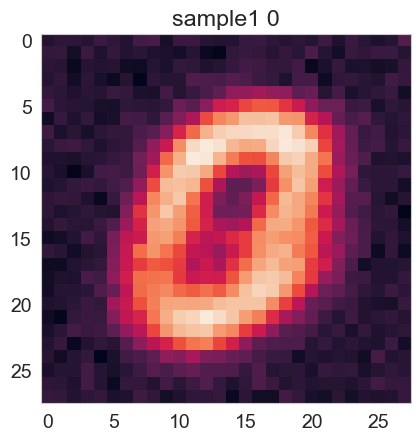

1
1 train loss: 0.1890
2
2 train loss: 0.1820
3
3 train loss: 0.1783
4
4 train loss: 0.1759
5
5 train loss: 0.1742


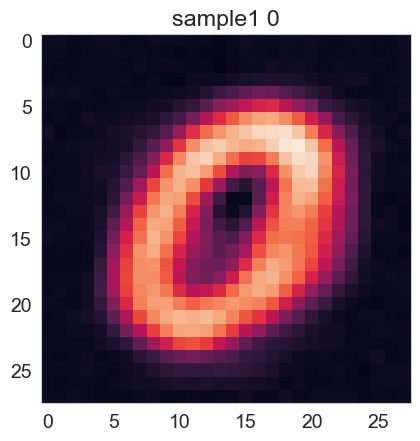

6
6 train loss: 0.1729
7
7 train loss: 0.1718
8
8 train loss: 0.1709
9
9 train loss: 0.1702
10
10 train loss: 0.1697


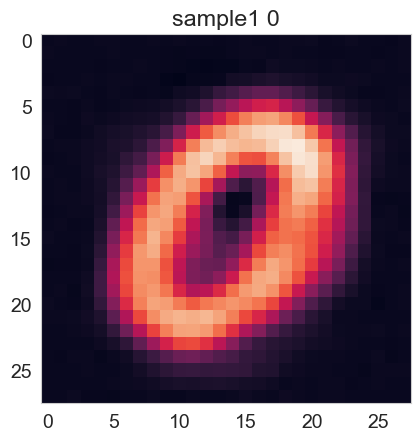

11
11 train loss: 0.1692
12
12 train loss: 0.1687
13
13 train loss: 0.1683
14
14 train loss: 0.1680
15
15 train loss: 0.1678


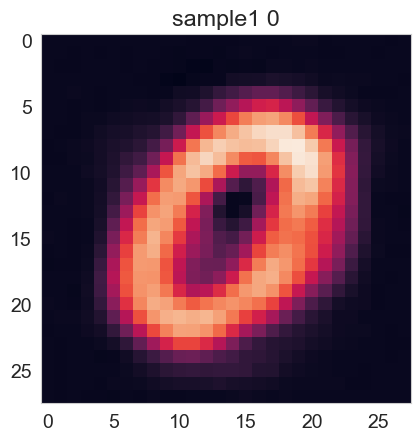

16
16 train loss: 0.1675
17
17 train loss: 0.1673
18
18 train loss: 0.1671
19
19 train loss: 0.1670


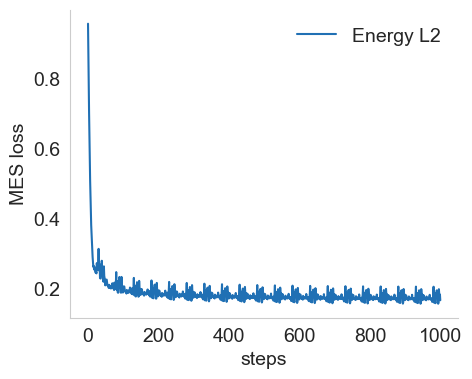

0
0 train loss: 0.2137


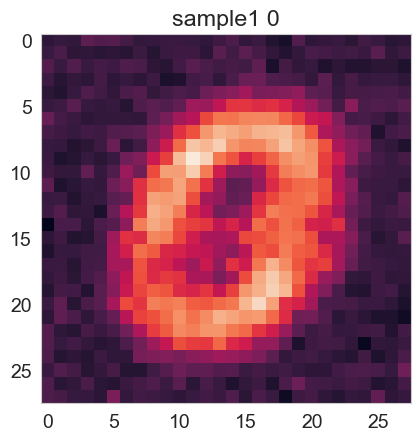

1
1 train loss: 0.1960
2
2 train loss: 0.1907
3
3 train loss: 0.1881
4
4 train loss: 0.1864
5
5 train loss: 0.1853


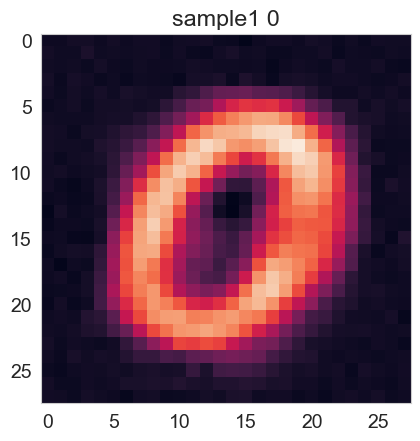

6
6 train loss: 0.1844
7
7 train loss: 0.1837
8
8 train loss: 0.1831
9
9 train loss: 0.1825
10
10 train loss: 0.1821


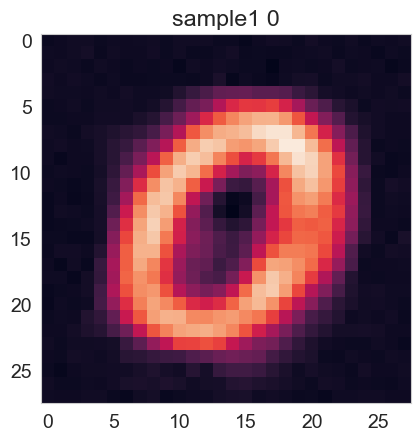

11
11 train loss: 0.1817
12
12 train loss: 0.1813
13
13 train loss: 0.1809
14
14 train loss: 0.1806
15
15 train loss: 0.1804


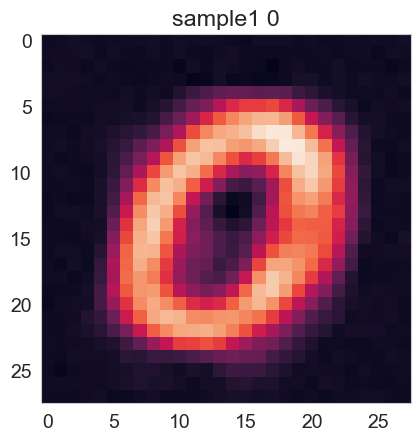

16
16 train loss: 0.1801
17
17 train loss: 0.1798
18
18 train loss: 0.1796
19
19 train loss: 0.1794


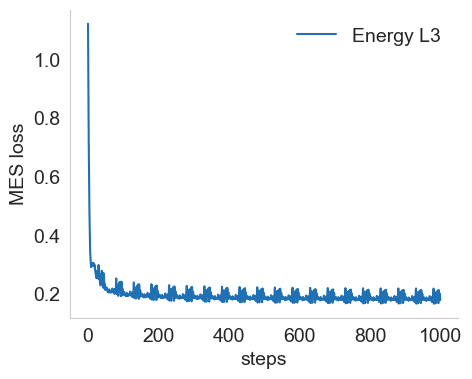

In [36]:
control_l1_decoder, control_l1_loss = decode_rise_time(0,control_model)
control_l2_decoder, control_l2_loss = decode_rise_time(1,control_model)
control_l3_decoder, control_l3_loss = decode_rise_time(2,control_model)

Save decoders

In [ ]:
energy_decoders=[energy_l1_decoder,energy_l2_decoder,energy_l3_decoder]
control_decoders=[control_l1_decoder,control_l2_decoder,control_l3_decoder]
for idx, decoder in enumerate(energy_decoders):
    torch.save(decoder,'base_energy\\decoder{}.pth'.format(idx))
for idx, decoder in enumerate(control_decoders):
    torch.save(decoder,'base_control\\decoder{}.pth'.format(idx))

## Figure 3

**Figure 3b**

Text(0, 0.5, 'MSE loss')

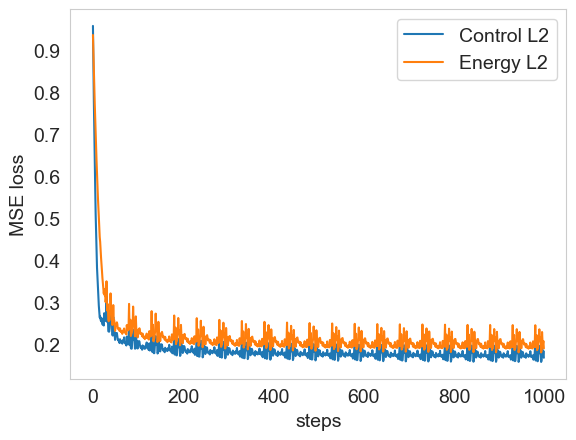

In [37]:
plt.plot(control_l2_loss,label='Control L2')
plt.plot(energy_l2_loss,label='Energy L2')
plt.legend()
plt.xlabel('steps')
plt.ylabel('MSE loss')

In [66]:
def plot_projection(decoder,layer_clamp_E,layer,type):
    n_classes=10
    # plot decoding of clamped internal representations 
    fig, axes = plt.subplots(1, 10, figsize=(10, 2))
    set_seeds()
    with torch.no_grad():
        for proj_class in range(n_classes):
            img1 = decoder(torch.tensor(layer_clamp_E[proj_class].astype('float32')).to(device).view(-1, hidden_dim[layer])).reshape(28, 28).cpu()
            axes[proj_class].imshow(img1, cmap='viridis')
            axes[proj_class].set_title(str(proj_class))
            # axes[0][proj_class].axis('off')
            axes[proj_class].tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
    
    fig.suptitle('projection back to image plane layer %i with occluded input' % (layer+1))
    axes[0].set_ylabel('{}'.format(type), rotation=0, labelpad=40)
    
    plt.tight_layout()
    plt.show()

**Figure 3d: Projections no input**

**Projections layer 1**

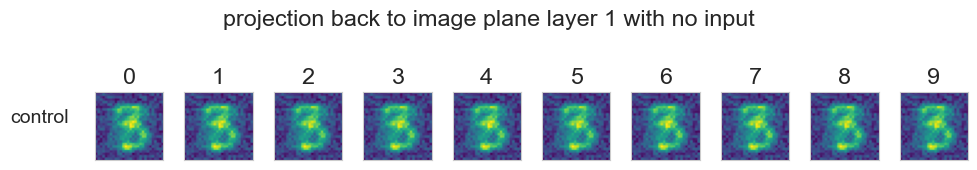

In [42]:
type='control'
plot_projection(control_decoders[0],control_l1_clamp_E,0,type)

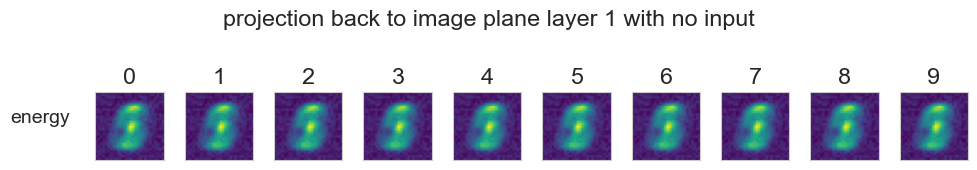

In [43]:
type='energy'
plot_projection(energy_decoders[0],energy_l1_clamp_E,0,type)

**Projections layer 2**

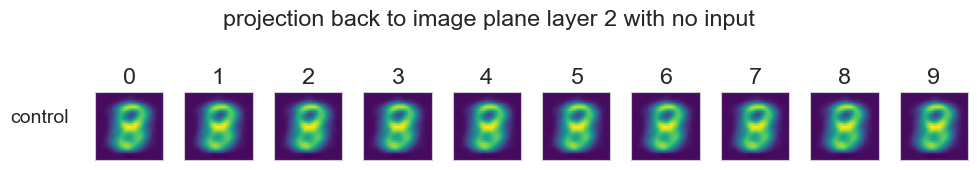

In [44]:
type='control'
plot_projection(control_decoders[1],control_l2_clamp_E,1,type)

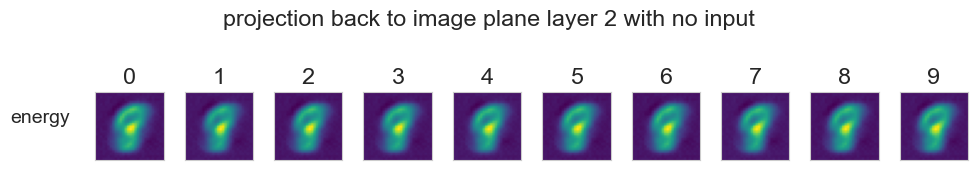

In [45]:
type='energy'
plot_projection(energy_decoders[1],energy_l2_clamp_E,1,type)

**Projections layer 3**

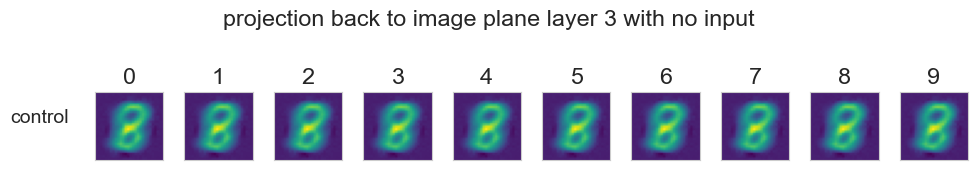

In [46]:
type='control'
plot_projection(control_decoders[2],control_l3_clamp_E,2,type)

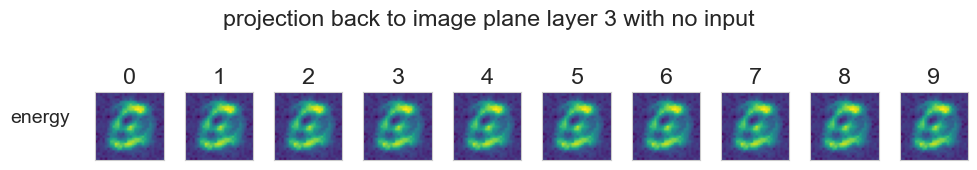

In [47]:
type='energy'
plot_projection(energy_decoders[2],control_l3_clamp_E,2,type)

**Figure 3c: Projections occluded input**

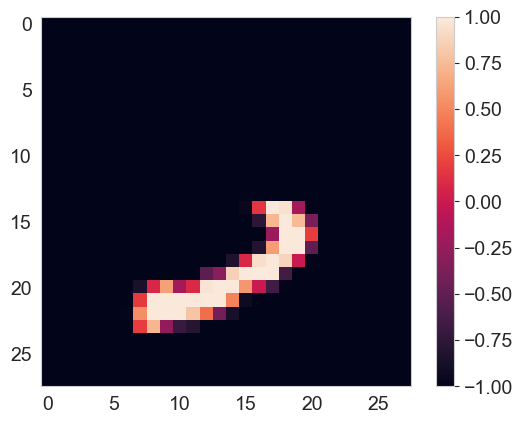

In [48]:
test_loader2 = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
for i, (data,target) in enumerate(test_loader2):
    if i==1:
        break
data[30][0][:14] = -1

# Using image 30 from the first batch of test_loader2, with top image half occluded
plt.imshow(data[30][0])
plt.colorbar()

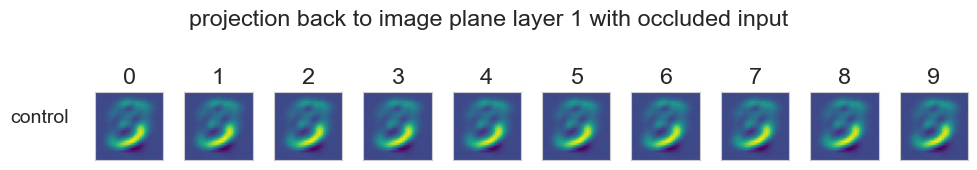

In [117]:
type='control'
plot_projection(control_decoders[0],control_occluded_l1_clamp_E,0,type)

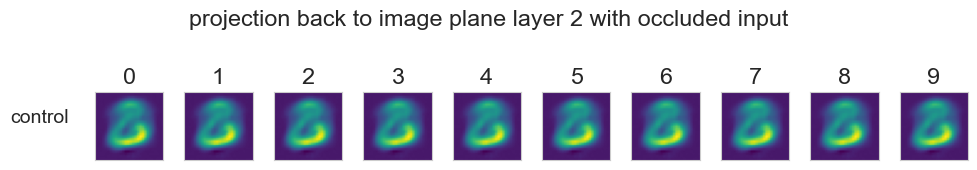

In [118]:
type='control'
plot_projection(control_decoders[1],control_occluded_l2_clamp_E,1,type)

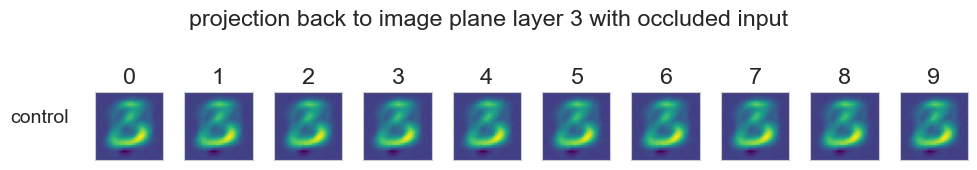

In [119]:
type='control'
plot_projection(control_decoders[2],control_occluded_l3_clamp_E,2,type)

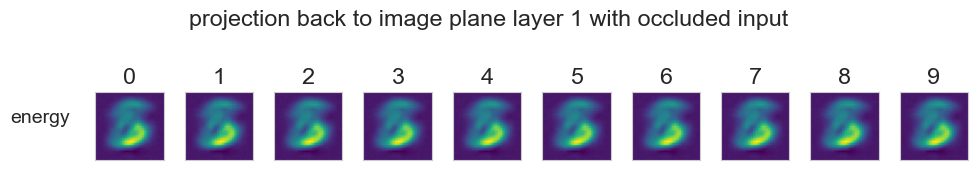

In [120]:
type='energy'
plot_projection(energy_decoders[0],energy_occluded_l1_clamp_E,0,type)

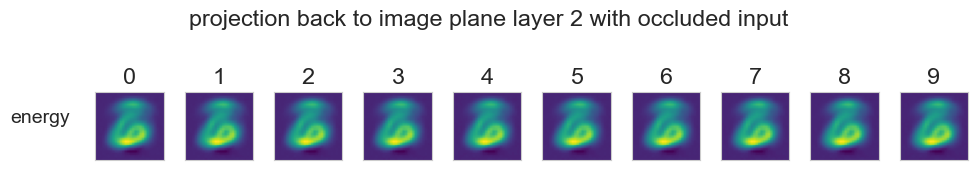

In [121]:
type='energy'
plot_projection(energy_decoders[1],energy_occluded_l2_clamp_E,1,type)

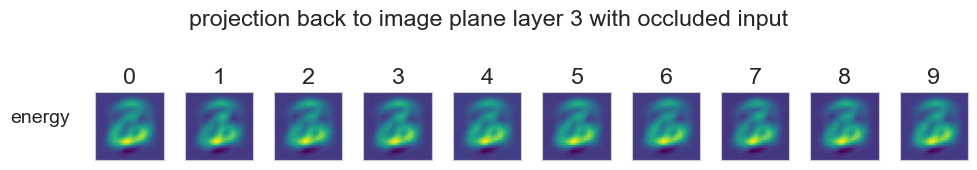

In [122]:
type='energy'
plot_projection(energy_decoders[2],energy_occluded_l3_clamp_E,2,type)

**Figure 3e: Pair-wise representational similarity**

In [57]:
# test function
def get_energy_for_class(model, test_loader, time_steps, cls):
    model.eval()

    spikes1, spikes2, spikes3 = [],[],[]
    
    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):

        data=data[target==cls]
        target=target[target==cls]

        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)
        
        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden(data.size(0))

            spikes_batch1=[]
            spikes_batch2=[]
            spikes_batch3=[]
            
            #log_softmax_outputs, hidden, errors = model.inference(data, hidden, time_steps)
            for t in range(time_steps):
                log_softmax, hidden = model.forward(data, hidden)

                spikes_batch1.append(torch.abs(hidden[1]).sum(axis=0))
                spikes_batch2.append(torch.abs(hidden[5]).sum(axis=0))
                spikes_batch3.append(torch.abs(hidden[9]).sum(axis=0))

        spikes1.append(torch.stack(spikes_batch1))
        spikes2.append(torch.stack(spikes_batch2))
        spikes3.append(torch.stack(spikes_batch3))
        
    spikes1 = torch.stack(spikes1)
    spikes2 = torch.stack(spikes2)
    spikes3 = torch.stack(spikes3)

    #return  spikes1/len(test_loader.dataset)/hidden_dim[0], spikes2/len(test_loader.dataset)/hidden_dim[1], spikes3/len(test_loader.dataset)/hidden_dim[2], torch.sum(energy1/len(test_loader.dataset))/energy1.shape[1], torch.sum(energy2/len(test_loader.dataset))/energy2.shape[1], torch.sum(energy3/len(test_loader.dataset))/energy2.shape[1]
    #return  errors, spikes1/len(test_loader.dataset)/hidden_dim[0], spikes2/len(test_loader.dataset)/hidden_dim[1], spikes3/len(test_loader.dataset)/hidden_dim[2], torch.sum(energy1/len(test_loader.dataset))/energy1.shape[1], torch.sum(energy2/len(test_loader.dataset))/energy2.shape[1], torch.sum(energy3/len(test_loader.dataset))/energy2.shape[1]
    return torch.sum(torch.sum(spikes1,axis=1),axis=0)/len(test_loader.dataset)/10/hidden_dim[0]/time_steps, torch.sum(torch.sum(spikes2,axis=1),axis=0)/len(test_loader.dataset)/10/hidden_dim[1]/time_steps, torch.sum(torch.sum(spikes3,axis=1),axis=0)/len(test_loader.dataset)/10/hidden_dim[2]/time_steps


# test function
def get_energy_for_class_rise_time(model, test_loader, time_steps, cls):
    model.eval()

    spikes1, spikes2, spikes3 = [],[],[]
    
    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):

        data=data[target==cls]
        target=target[target==cls]

        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)
        
        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden_rise_time(data.size(0))

            spikes_batch1=[]
            spikes_batch2=[]
            spikes_batch3=[]
            
            #log_softmax_outputs, hidden, errors = model.inference(data, hidden, time_steps)
            for t in range(time_steps):
                log_softmax, hidden = model.forward_rise_time(data, hidden)

                spikes_batch1.append(torch.abs(hidden[1]).sum(axis=0))
                spikes_batch2.append(torch.abs(hidden[5]).sum(axis=0))
                spikes_batch3.append(torch.abs(hidden[9]).sum(axis=0))

        spikes1.append(torch.stack(spikes_batch1))
        spikes2.append(torch.stack(spikes_batch2))
        spikes3.append(torch.stack(spikes_batch3))
        
    spikes1 = torch.stack(spikes1)
    spikes2 = torch.stack(spikes2)
    spikes3 = torch.stack(spikes3)

    #return  spikes1/len(test_loader.dataset)/hidden_dim[0], spikes2/len(test_loader.dataset)/hidden_dim[1], spikes3/len(test_loader.dataset)/hidden_dim[2], torch.sum(energy1/len(test_loader.dataset))/energy1.shape[1], torch.sum(energy2/len(test_loader.dataset))/energy2.shape[1], torch.sum(energy3/len(test_loader.dataset))/energy2.shape[1]
    #return  errors, spikes1/len(test_loader.dataset)/hidden_dim[0], spikes2/len(test_loader.dataset)/hidden_dim[1], spikes3/len(test_loader.dataset)/hidden_dim[2], torch.sum(energy1/len(test_loader.dataset))/energy1.shape[1], torch.sum(energy2/len(test_loader.dataset))/energy2.shape[1], torch.sum(energy3/len(test_loader.dataset))/energy2.shape[1]
    return torch.sum(torch.sum(spikes1,axis=1),axis=0)/len(test_loader.dataset)/10/hidden_dim[0]/time_steps, torch.sum(torch.sum(spikes2,axis=1),axis=0)/len(test_loader.dataset)/10/hidden_dim[1]/time_steps, torch.sum(torch.sum(spikes3,axis=1),axis=0)/len(test_loader.dataset)/10/hidden_dim[2]/time_steps



In [58]:
energy_spikes_classes_layer1, energy_spikes_classes_layer2, energy_spikes_classes_layer3 = [],[],[]
for i in range(10):
    energy_spikes1, energy_spikes2, energy_spikes3 = get_energy_for_class_rise_time(energy_model, test_loader, T, i)
    energy_spikes_classes_layer1.append(energy_spikes1.cpu())
    energy_spikes_classes_layer2.append(energy_spikes2.cpu())
    energy_spikes_classes_layer3.append(energy_spikes3.cpu())

In [59]:
control_spikes_classes_layer1, control_spikes_classes_layer2, control_spikes_classes_layer3 = [],[],[]
for i in range(10):
    control_spikes1, control_spikes2, control_spikes3 = get_energy_for_class_rise_time(control_model, test_loader, T, i)
    control_spikes_classes_layer1.append(control_spikes1.cpu())
    control_spikes_classes_layer2.append(control_spikes2.cpu())
    control_spikes_classes_layer3.append(control_spikes3.cpu())

In [60]:
energy_spikes_classes_layer1 = torch.stack(energy_spikes_classes_layer1).numpy()
energy_spikes_classes_layer2 = torch.stack(energy_spikes_classes_layer2).numpy()
energy_spikes_classes_layer3 = torch.stack(energy_spikes_classes_layer3).numpy()

control_spikes_classes_layer1 = torch.stack(control_spikes_classes_layer1).numpy()
control_spikes_classes_layer2 = torch.stack(control_spikes_classes_layer2).numpy()
control_spikes_classes_layer3 = torch.stack(control_spikes_classes_layer3).numpy()

In [61]:
energy_spikes_classes_layer1.shape,energy_l1_clamp_E.shape

((10, 600), (10, 600))

In [62]:
#from itertools import izip
from math import sqrt

def cosine_similarity(a, b):
    if len(a) != len(b):
        print("a and b must be same length")
    numerator = sum(tup[0] * tup[1] for tup in zip(a,b))
    denoma = sum(avalue ** 2 for avalue in a)
    denomb = sum(bvalue ** 2 for bvalue in b)
    result = numerator / (sqrt(denoma)*sqrt(denomb))
    return result

In [63]:
def get_representational_similarity(a,b):
    res=[]
    for i in range(10):
        for j in range(10):
            res.append(cosine_similarity(a[i],b[j]))
    return np.array(res).reshape(10,10)

In [64]:
rep_sim_control1 = get_representational_similarity(control_l1_clamp_E, control_spikes_classes_layer1)
rep_sim_control2 = get_representational_similarity(control_l2_clamp_E, control_spikes_classes_layer2)
rep_sim_control3 = get_representational_similarity(control_l3_clamp_E, control_spikes_classes_layer3)

rep_sim_energy1 = get_representational_similarity(energy_l1_clamp_E, energy_spikes_classes_layer1)
rep_sim_energy2 = get_representational_similarity(energy_l2_clamp_E, energy_spikes_classes_layer2)
rep_sim_energy3 = get_representational_similarity(energy_l3_clamp_E, energy_spikes_classes_layer3)

Text(0, 0.5, 'L3\nclamped')

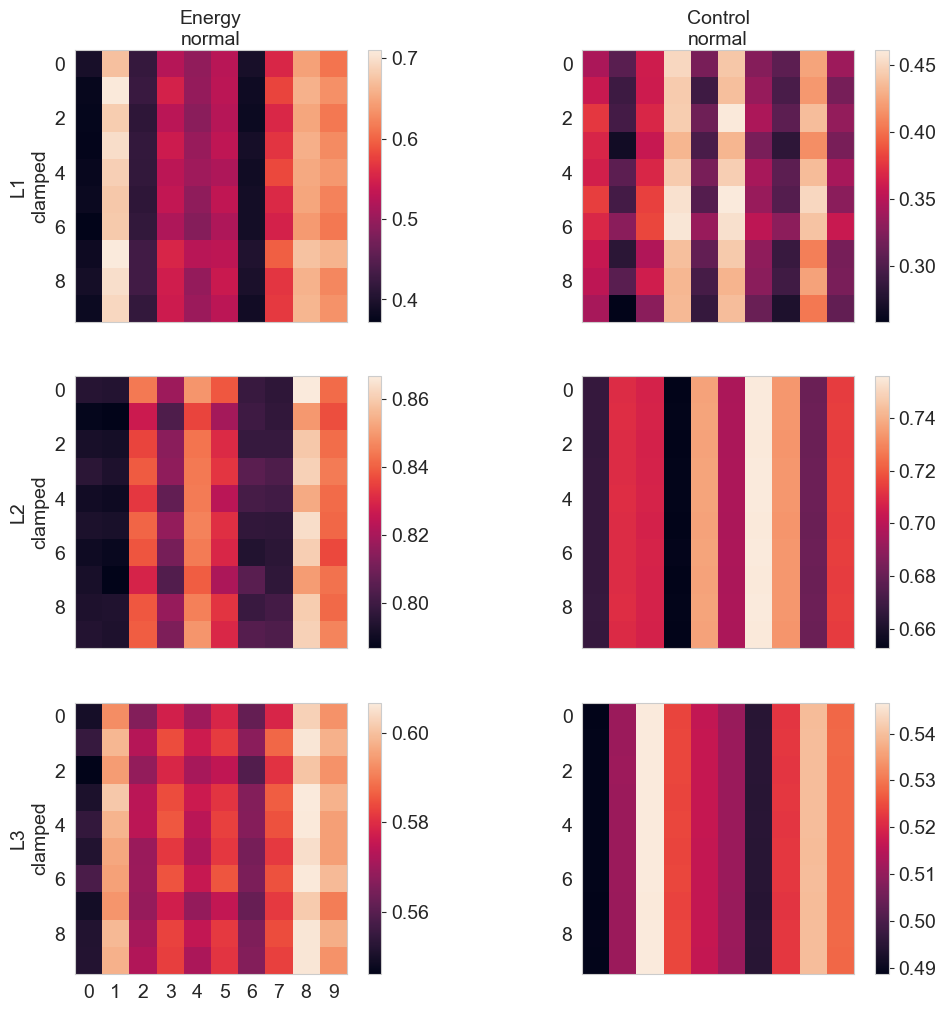

In [65]:
fig,ax=plt.subplots(3,2,figsize=(12, 12))
img = ax[0][1].imshow(rep_sim_control1)
plt.colorbar(img,ax=ax[0][1])
img = ax[1][1].imshow(rep_sim_control2)
plt.colorbar(img,ax=ax[1][1])
img = ax[2][1].imshow(rep_sim_control3)
plt.colorbar(img,ax=ax[2][1])
img = ax[0][0].imshow(rep_sim_energy1)
plt.colorbar(img,ax=ax[0][0])
img = ax[1][0].imshow(rep_sim_energy2)
plt.colorbar(img,ax=ax[1][0])
img = ax[2][0].imshow(rep_sim_energy3)
plt.colorbar(img,ax=ax[2][0])

ax[0][0].xaxis.set_label_position('top') 
ax[0][1].xaxis.set_label_position('top') 
ax[0][0].set_xlabel('Energy\nnormal')
ax[0][1].set_xlabel('Control\nnormal')

ax[0][0].set_xticks([])
ax[0][1].set_xticks([])
ax[1][0].set_xticks([])
ax[1][1].set_xticks([])
ax[2][0].set_xticks(range(10))
ax[2][1].set_xticks([])

ax[0][0].set_ylabel('L1\nclamped')
ax[1][0].set_ylabel('L2\nclamped')
ax[2][0].set_ylabel('L3\nclamped')

#plt.colorbar(img,ax=ax)
#ax[0][0].set_title('Energy')
#ax[0][1].set_title('Control')

## Figure 4

In [73]:
def clamped_generate_surprise(self, test_class, zeros, h_clamped, T, clamp_value=0.5, clamp_bool=False, batch=False, noise=None):
        """
        generate representations with mem of read out clamped
        :param test_class: which class is clamped
        :param zeros: input containing zeros, absence of input
        :param h: hidden states
        :param T: sequence length
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):
            if clamp_bool:
                if not batch:
                    h_clamped[-1][0] = -clamp_value
                    h_clamped[-1][0, test_class] = clamp_value
                else:
                    h_clamped[-1][:, :] = torch.full(h_clamped[-1].size(), -clamp_value).to(device)
                    h_clamped[-1][:, test_class] = clamp_value

            if noise is not None:
                    h_clamped[-1][:] += noise

            # if t==0:
            #     print(h_clamped[-1])

            log_softmax, h_clamped = self.forward(zeros, h_clamped)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h_clamped)

        return log_softmax_hist, h_hist, h_clamped

In [74]:
test_loader2 = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
for i, (x,y) in enumerate(test_loader2):
    if i==0:
        break

In [75]:
# first batch has 17 images of 'zero'
x[y==0].shape

torch.Size([17, 1, 28, 28])

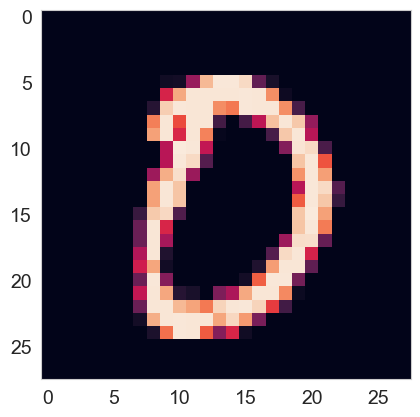

In [76]:
plt.imshow(x[y==0][16][0])

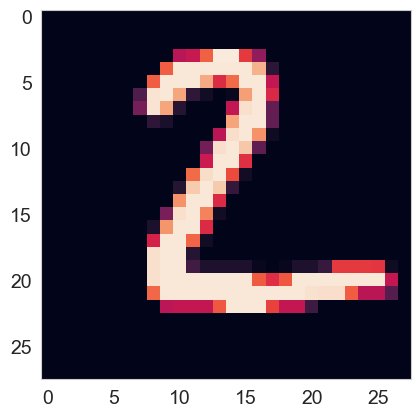

In [77]:
plt.imshow(x[1][0])

In [79]:
def clamped_generate_surprise(model, test_class, input, h_clamped, T, clamp_value=0.5, clamp_bool=False, batch=False, noise=None):
        """
        generate representations with mem of read out clamped
        :param test_class: which class is clamped
        :param input: input containing input, absence of input
        :param h: hidden states
        :param T: sequence length
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):
            if clamp_bool:
                if not batch:
                    h_clamped[-1][0] = -clamp_value
                    h_clamped[-1][0, test_class] = clamp_value
                else:
                    h_clamped[-1][:, :] = torch.full(h_clamped[-1].size(), -clamp_value).to(device)
                    h_clamped[-1][:, test_class] = clamp_value

            if noise is not None:
                    h_clamped[-1][:] += noise

            # if t==0:
            #     print(h_clamped[-1])

            log_softmax, h_clamped = model.forward(input, h_clamped)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h_clamped)

        return log_softmax_hist, h_hist, h_clamped

def clamped_generate_surprise_rise_time(model, test_class, input, h_clamped, T, clamp_value=0.5, clamp_bool=False, batch=False, noise=None):
        """
        generate representations with mem of read out clamped
        :param test_class: which class is clamped
        :param input: input containing input, absence of input
        :param h: hidden states
        :param T: sequence length
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):
            if clamp_bool:
                if not batch:
                    h_clamped[-1][0] = -clamp_value
                    h_clamped[-1][0, test_class] = clamp_value
                else:
                    h_clamped[-1][:, :] = torch.full(h_clamped[-1].size(), -clamp_value).to(device)
                    h_clamped[-1][:, test_class] = clamp_value

            if noise is not None:
                    h_clamped[-1][:] += noise

            # if t==0:
            #     print(h_clamped[-1])

            log_softmax, h_clamped = model.forward_rise_time(input, h_clamped)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h_clamped)

        return log_softmax_hist, h_hist, h_clamped

In [83]:
def get_results(model,input_class,surprise_class,element,keep_time,return_diff):
    # clamped generation of internal representations 
    no_input = torch.zeros((1, IN_dim)).to(device)
    set_seeds()
    clamp_T = T 
    n_images = (y==input_class).sum()
    image = x[y==input_class][0][0].reshape(1,784).to(device)

    # Expected clamp class 
    if keep_time:
        l1_clamp_expected = np.zeros((n_images, int(T/2), hidden_dim[0]))
        l2_clamp_expected = np.zeros((n_images, int(T/2), hidden_dim[1]))
        l3_clamp_expected = np.zeros((n_images, int(T/2), hidden_dim[2]))
    else:
        l1_clamp_expected = np.zeros((1, hidden_dim[0]))
        l2_clamp_expected = np.zeros((1, hidden_dim[1]))
        l3_clamp_expected = np.zeros((1, hidden_dim[2]))
    clamp_class = input_class
    
    for image_idx in range(n_images):
        with torch.no_grad():
            model.eval()
    
            hidden_i = model.init_hidden(1)
    
            # no input for 25 timesteps before stimulus onset
            _, _, hidden_i = clamped_generate_surprise(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=1, clamp_bool=False)
            # clamped stimulus for 50 timesteps
            _, h_hist, hidden_i = clamped_generate_surprise(model, clamp_class, image, hidden_i, int(clamp_T / 2), clamp_value=1, clamp_bool=True)
            # no input for 25 timesteps after stimulus 
            _, _, hidden_i = clamped_generate_surprise(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=1, clamp_bool=False)
            
            if element == 'apical':
                l1_E = get_states([h_hist], 2, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                l2_E = get_states([h_hist], 6, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                l3_E = get_states([h_hist], 10, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)
            elif element == 'soma':
                l1_E = get_states([h_hist], 0, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                l2_E = get_states([h_hist], 4, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                l3_E = get_states([h_hist], 8, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)
            elif element == 'spikes':
                l1_E = get_states([h_hist], 1, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                l2_E = get_states([h_hist], 5, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                l3_E = get_states([h_hist], 9, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)

            if keep_time:
                l1_clamp_expected[image_idx] += np.squeeze(l1_E)
                l2_clamp_expected[image_idx] += np.squeeze(l2_E)
                l3_clamp_expected[image_idx] += np.squeeze(l3_E)
            else:
                l1_clamp_expected[image_idx] += np.squeeze(l1_E.mean(axis=1))
                l2_clamp_expected[image_idx] += np.squeeze(l2_E.mean(axis=1))
                l3_clamp_expected[image_idx] += np.squeeze(l3_E.mean(axis=1))
    
        torch.cuda.empty_cache()

    set_seeds()
    # Surprise clamp class 
    if keep_time:
        l1_clamp_surprise = np.zeros((n_images, int(T/2), hidden_dim[0]))
        l2_clamp_surprise = np.zeros((n_images, int(T/2), hidden_dim[1]))
        l3_clamp_surprise = np.zeros((n_images, int(T/2), hidden_dim[2]))
    else:
        l1_clamp_surprise = np.zeros((1, hidden_dim[0]))
        l2_clamp_surprise = np.zeros((1, hidden_dim[1]))
        l3_clamp_surprise = np.zeros((1, hidden_dim[2]))
    clamp_class = surprise_class
    
    for image_idx in range(n_images)[:1]:
        with torch.no_grad():
            model.eval()
    
            hidden_i = model.init_hidden(1)
    
            # no input for 25 timesteps before stimulus onset
            _, _, hidden_i = clamped_generate_surprise(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=1, clamp_bool=False)
            # clamped stimulus for 50 timesteps
            _, h_hist, hidden_i = clamped_generate_surprise(model, clamp_class, image, hidden_i, int(clamp_T / 2), clamp_value=1, clamp_bool=True)
            # no input for 25 timesteps after stimulus 
            _, _, hidden_i = clamped_generate_surprise(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=1, clamp_bool=False)
            
            #
            if element == 'apical':
                l1_E = get_states([h_hist], 2, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                l2_E = get_states([h_hist], 6, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                l3_E = get_states([h_hist], 10, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)
            elif element == 'soma':
                l1_E = get_states([h_hist], 0, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                l2_E = get_states([h_hist], 4, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                l3_E = get_states([h_hist], 8, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)
            elif element == 'spikes':
                l1_E = get_states([h_hist], 1, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                l2_E = get_states([h_hist], 5, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                l3_E = get_states([h_hist], 9, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)
                
            if keep_time:
                l1_clamp_surprise[image_idx] += np.squeeze(l1_E)
                l2_clamp_surprise[image_idx] += np.squeeze(l2_E)
                l3_clamp_surprise[image_idx] += np.squeeze(l3_E)
            else:
                l1_clamp_surprise[image_idx] += np.squeeze(l1_E.mean(axis=1))
                l2_clamp_surprise[image_idx] += np.squeeze(l2_E.mean(axis=1))
                l3_clamp_surprise[image_idx] += np.squeeze(l3_E.mean(axis=1))
    
        torch.cuda.empty_cache()
    if return_diff:
        return l1_clamp_surprise-l1_clamp_expected, l2_clamp_surprise-l2_clamp_expected, l3_clamp_surprise-l3_clamp_expected
    else: 
        return l1_clamp_surprise,l1_clamp_expected, l2_clamp_surprise,l2_clamp_expected, l3_clamp_surprise,l3_clamp_expected


def get_results_rise_time(model,input_class,surprise_class,element,keep_time,return_diff):
    # clamped generation of internal representations 
    no_input = torch.zeros((1, IN_dim)).to(device)
    set_seeds()
    clamp_T = T 
    n_images = (y==input_class).sum()
    image = x[y==input_class][0][0].reshape(1,784).to(device)

    # Expected clamp class 
    if keep_time:
        l1_clamp_expected = np.zeros((n_images, int(T/2), hidden_dim[0]))
        l2_clamp_expected = np.zeros((n_images, int(T/2), hidden_dim[1]))
        l3_clamp_expected = np.zeros((n_images, int(T/2), hidden_dim[2]))
    else:
        l1_clamp_expected = np.zeros((1, hidden_dim[0]))
        l2_clamp_expected = np.zeros((1, hidden_dim[1]))
        l3_clamp_expected = np.zeros((1, hidden_dim[2]))
    clamp_class = input_class
    
    for image_idx in range(n_images):
        with torch.no_grad():
            model.eval()
    
            hidden_i = model.init_hidden_rise_time(1)
    
            # no input for 25 timesteps before stimulus onset
            _, _, hidden_i = clamped_generate_surprise_rise_time(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=1, clamp_bool=False)
            # clamped stimulus for 50 timesteps
            _, h_hist, hidden_i = clamped_generate_surprise_rise_time(model, clamp_class, image, hidden_i, int(clamp_T / 2), clamp_value=1, clamp_bool=True)
            # no input for 25 timesteps after stimulus 
            _, _, hidden_i = clamped_generate_surprise_rise_time(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=1, clamp_bool=False)
            
            if element == 'apical':
                l1_E = get_states([h_hist], 2, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                l2_E = get_states([h_hist], 7, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                l3_E = get_states([h_hist], 12, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)
            elif element == 'soma':
                l1_E = get_states([h_hist], 0, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                l2_E = get_states([h_hist], 5, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                l3_E = get_states([h_hist], 10, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)
            elif element == 'spikes':
                l1_E = get_states([h_hist], 1, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                l2_E = get_states([h_hist], 6, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                l3_E = get_states([h_hist], 11, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)

            if keep_time:
                l1_clamp_expected[image_idx] += np.squeeze(l1_E)
                l2_clamp_expected[image_idx] += np.squeeze(l2_E)
                l3_clamp_expected[image_idx] += np.squeeze(l3_E)
            else:
                l1_clamp_expected[image_idx] += np.squeeze(l1_E.mean(axis=1))
                l2_clamp_expected[image_idx] += np.squeeze(l2_E.mean(axis=1))
                l3_clamp_expected[image_idx] += np.squeeze(l3_E.mean(axis=1))
    
        torch.cuda.empty_cache()

    set_seeds()
    # Surprise clamp class 
    if keep_time:
        l1_clamp_surprise = np.zeros((n_images, int(T/2), hidden_dim[0]))
        l2_clamp_surprise = np.zeros((n_images, int(T/2), hidden_dim[1]))
        l3_clamp_surprise = np.zeros((n_images, int(T/2), hidden_dim[2]))
    else:
        l1_clamp_surprise = np.zeros((1, hidden_dim[0]))
        l2_clamp_surprise = np.zeros((1, hidden_dim[1]))
        l3_clamp_surprise = np.zeros((1, hidden_dim[2]))
    clamp_class = surprise_class
    
    for image_idx in range(n_images)[:1]:
        with torch.no_grad():
            model.eval()
    
            hidden_i = model.init_hidden_rise_time(1)
    
            # no input for 25 timesteps before stimulus onset
            _, _, hidden_i = clamped_generate_surprise_rise_time(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=1, clamp_bool=False)
            # clamped stimulus for 50 timesteps
            _, h_hist, hidden_i = clamped_generate_surprise_rise_time(model, clamp_class, image, hidden_i, int(clamp_T / 2), clamp_value=1, clamp_bool=True)
            # no input for 25 timesteps after stimulus 
            _, _, hidden_i = clamped_generate_surprise_rise_time(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=1, clamp_bool=False)
            
            #
            if element == 'apical':
                l1_E = get_states([h_hist], 2, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                l2_E = get_states([h_hist], 7, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                l3_E = get_states([h_hist], 12, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)
            elif element == 'soma':
                l1_E = get_states([h_hist], 0, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                l2_E = get_states([h_hist], 5, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                l3_E = get_states([h_hist], 10, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)
            elif element == 'spikes':
                l1_E = get_states([h_hist], 1, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                l2_E = get_states([h_hist], 6, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                l3_E = get_states([h_hist], 11, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)
                
            if keep_time:
                l1_clamp_surprise[image_idx] += np.squeeze(l1_E)
                l2_clamp_surprise[image_idx] += np.squeeze(l2_E)
                l3_clamp_surprise[image_idx] += np.squeeze(l3_E)
            else:
                l1_clamp_surprise[image_idx] += np.squeeze(l1_E.mean(axis=1))
                l2_clamp_surprise[image_idx] += np.squeeze(l2_E.mean(axis=1))
                l3_clamp_surprise[image_idx] += np.squeeze(l3_E.mean(axis=1))
    
        torch.cuda.empty_cache()
    if return_diff:
        return l1_clamp_surprise-l1_clamp_expected, l2_clamp_surprise-l2_clamp_expected, l3_clamp_surprise-l3_clamp_expected
    else: 
        return l1_clamp_surprise,l1_clamp_expected, l2_clamp_surprise,l2_clamp_expected, l3_clamp_surprise,l3_clamp_expected

In [103]:
input_class = 2
surprise_class = 7
model = control_model
element='apical'
keep_time=True
return_diff=False
if return_diff:
    l1_diff_control, l2_diff_control, l3_diff_control = get_results_rise_time(model,input_class,surprise_class,element,keep_time,return_diff)
else:
    l1_surprise_control, l1_expected_control, l2_surprise_control, l2_expected_control, l3_surprise_control, l3_expected_control = get_results_rise_time(model,input_class,surprise_class,element,keep_time,return_diff)

In [104]:
input_class = 2
surprise_class = 7
model = energy_model
element='apical'
keep_time=True
return_diff=False
if return_diff:
    l1_diff_energy, l2_diff_energy, l3_diff_energy = get_results_rise_time(model,input_class,surprise_class,element,keep_time,return_diff)
else:
    l1_surprise_energy, l1_expected_energy, l2_surprise_energy, l2_expected_energy, l3_surprise_energy, l3_expected_energy = get_results_rise_time(model,input_class,surprise_class,element,keep_time,return_diff)

#### Figure 3c: Apical tuft

not averaged over time, or averaged over time

Text(0, 0.5, 'L3\nPercentage')

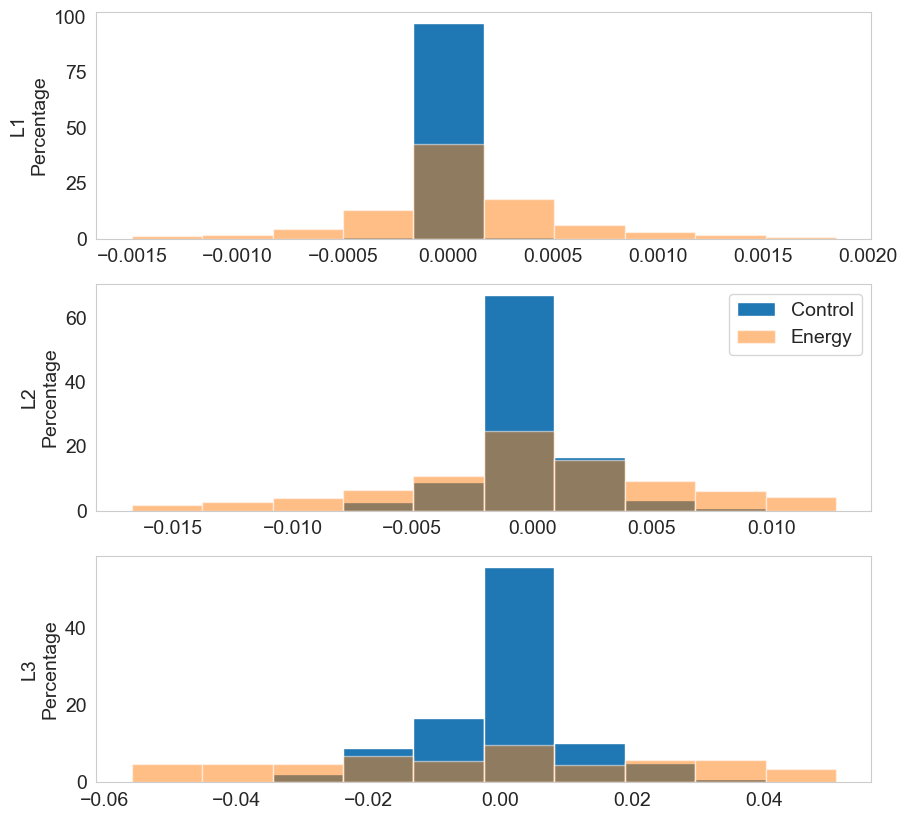

In [92]:
fig,ax=plt.subplots(3,1,figsize=(10, 10))
_,bins1,_ = ax[0].hist(l1_diff_control[0].flatten(),weights=[100/50/l1_diff_control[0].shape[1]]*50*l1_diff_control[0].shape[1],bins=10)
_,bins2,_ = ax[1].hist(l2_diff_control[0].flatten(),weights=[100/50/l2_diff_control[0].shape[1]]*50*l2_diff_control[0].shape[1],bins=10,label='Control')
_,bins3,_ = ax[2].hist(l3_diff_control[0].flatten(),weights=[100/50/l3_diff_control[0].shape[1]]*50*l3_diff_control[0].shape[1],bins=10)

ax[0].hist(l1_diff_energy[0].flatten(),weights=[100/50/l1_diff_energy[0].shape[1]]*50*l1_diff_energy[0].shape[1],bins=bins1,alpha=0.5)
ax[1].hist(l2_diff_energy[0].flatten(),weights=[100/50/l2_diff_energy[0].shape[1]]*50*l2_diff_energy[0].shape[1],bins=bins2,alpha=0.5,label='Energy')
ax[2].hist(l3_diff_energy[0].flatten(),weights=[100/50/l3_diff_energy[0].shape[1]]*50*l3_diff_energy[0].shape[1],bins=bins3,alpha=0.5)

ax[1].legend()

ax[0].xaxis.set_label_position('top') 
ax[0].xaxis.set_label_position('top') 

ax[0].set_ylabel('L1\nPercentage')
ax[1].set_ylabel('L2\nPercentage')
ax[2].set_ylabel('L3\nPercentage')

Text(0, 0.5, 'L3\nPercentage')

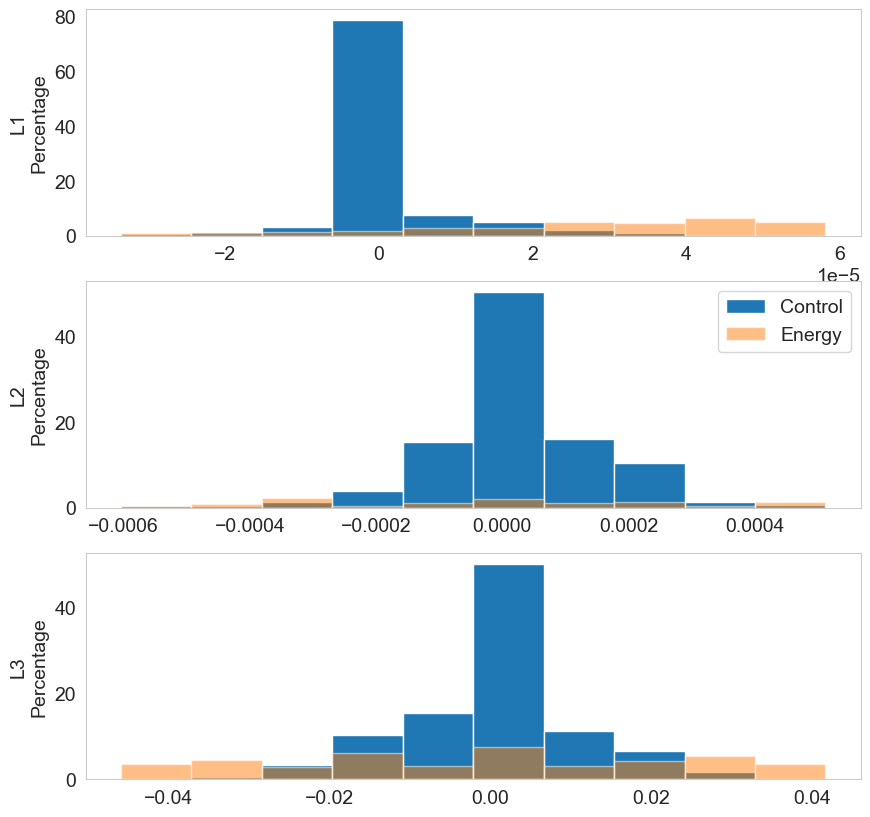

In [93]:
fig,ax=plt.subplots(3,1,figsize=(10, 10))
_,bins1,_ = ax[0].hist(l1_diff_control[0].mean(axis=0),weights=[100/l1_diff_control[0].shape[1]]*l1_diff_control[0].shape[1],bins=10)
_,bins2,_ = ax[1].hist(l2_diff_control[0].mean(axis=0),weights=[100/l2_diff_control[0].shape[1]]*l2_diff_control[0].shape[1],bins=10,label='Control')
_,bins3,_ = ax[2].hist(l3_diff_control[0].mean(axis=0),weights=[100/l3_diff_control[0].shape[1]]*l3_diff_control[0].shape[1],bins=10)

ax[0].hist(l1_diff_energy[0].mean(axis=0),weights=[100/l1_diff_energy[0].shape[1]]*l1_diff_energy[0].shape[1],bins=bins1,alpha=0.5)
ax[1].hist(l2_diff_energy[0].mean(axis=0),weights=[100/l2_diff_energy[0].shape[1]]*l2_diff_energy[0].shape[1],bins=bins2,alpha=0.5,label='Energy')
ax[2].hist(l3_diff_energy[0].mean(axis=0),weights=[100/l3_diff_energy[0].shape[1]]*l3_diff_energy[0].shape[1],bins=bins3,alpha=0.5)

ax[1].legend()

ax[0].xaxis.set_label_position('top') 
ax[0].xaxis.set_label_position('top') 

ax[0].set_ylabel('L1\nPercentage')
ax[1].set_ylabel('L2\nPercentage')
ax[2].set_ylabel('L3\nPercentage')

#### Figure 3d: Soma

not averaged over time, or averaged over time

Text(0, 0.5, 'L3\nPercentage')

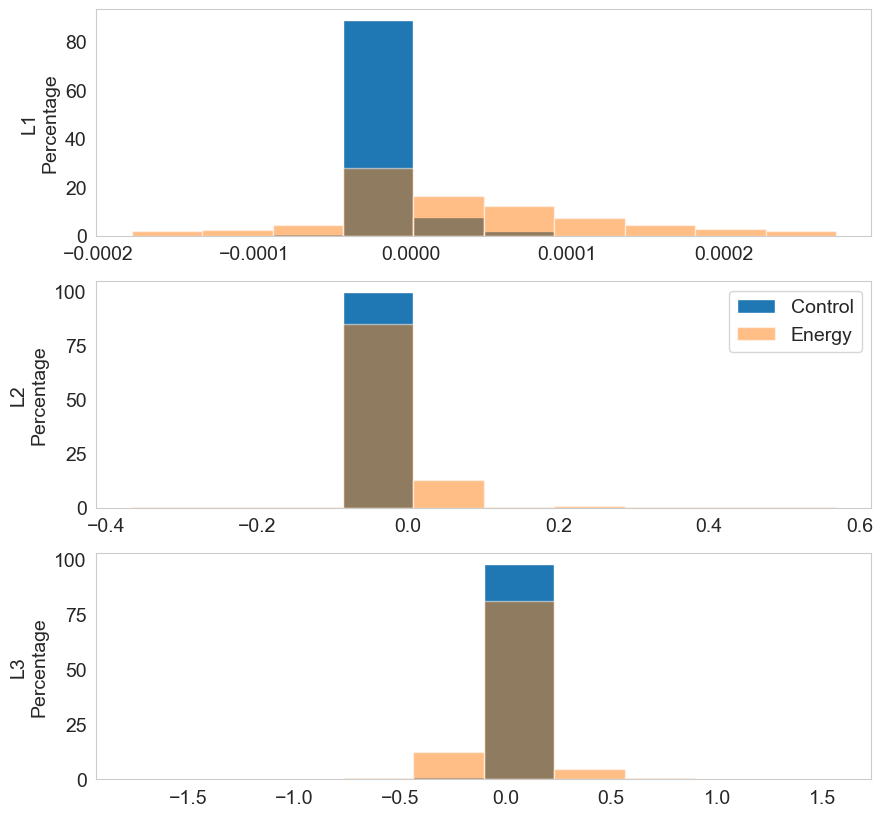

In [88]:
fig,ax=plt.subplots(3,1,figsize=(10, 10))
_,bins1,_ = ax[0].hist(l1_diff_control[0].flatten(),weights=[100/50/l1_diff_control[0].shape[1]]*50*l1_diff_control[0].shape[1],bins=10)
_,bins2,_ = ax[1].hist(l2_diff_control[0].flatten(),weights=[100/50/l2_diff_control[0].shape[1]]*50*l2_diff_control[0].shape[1],bins=10,label='Control')
_,bins3,_ = ax[2].hist(l3_diff_control[0].flatten(),weights=[100/50/l3_diff_control[0].shape[1]]*50*l3_diff_control[0].shape[1],bins=10)

ax[0].hist(l1_diff_energy[0].flatten(),weights=[100/50/l1_diff_energy[0].shape[1]]*50*l1_diff_energy[0].shape[1],bins=bins1,alpha=0.5)
ax[1].hist(l2_diff_energy[0].flatten(),weights=[100/50/l2_diff_energy[0].shape[1]]*50*l2_diff_energy[0].shape[1],bins=bins2,alpha=0.5,label='Energy')
ax[2].hist(l3_diff_energy[0].flatten(),weights=[100/50/l3_diff_energy[0].shape[1]]*50*l3_diff_energy[0].shape[1],bins=bins3,alpha=0.5)

ax[1].legend()

ax[0].xaxis.set_label_position('top') 
ax[0].xaxis.set_label_position('top') 

ax[0].set_ylabel('L1\nPercentage')
ax[1].set_ylabel('L2\nPercentage')
ax[2].set_ylabel('L3\nPercentage')

Text(0, 0.5, 'L3\nPercentage')

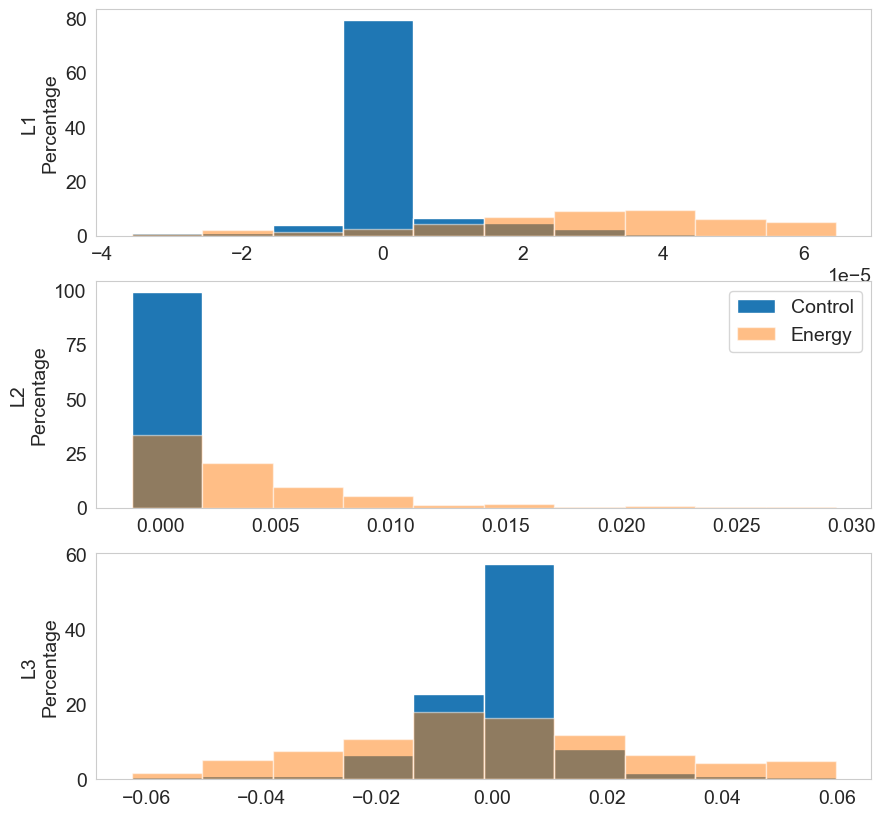

In [89]:
fig,ax=plt.subplots(3,1,figsize=(10, 10))
_,bins1,_ = ax[0].hist(l1_diff_control[0].mean(axis=0),weights=[100/l1_diff_control[0].shape[1]]*l1_diff_control[0].shape[1],bins=10)
_,bins2,_ = ax[1].hist(l2_diff_control[0].mean(axis=0),weights=[100/l2_diff_control[0].shape[1]]*l2_diff_control[0].shape[1],bins=10,label='Control')
_,bins3,_ = ax[2].hist(l3_diff_control[0].mean(axis=0),weights=[100/l3_diff_control[0].shape[1]]*l3_diff_control[0].shape[1],bins=10)

ax[0].hist(l1_diff_energy[0].mean(axis=0),weights=[100/l1_diff_energy[0].shape[1]]*l1_diff_energy[0].shape[1],bins=bins1,alpha=0.5)
ax[1].hist(l2_diff_energy[0].mean(axis=0),weights=[100/l2_diff_energy[0].shape[1]]*l2_diff_energy[0].shape[1],bins=bins2,alpha=0.5,label='Energy')
ax[2].hist(l3_diff_energy[0].mean(axis=0),weights=[100/l3_diff_energy[0].shape[1]]*l3_diff_energy[0].shape[1],bins=bins3,alpha=0.5)

ax[1].legend()

ax[0].xaxis.set_label_position('top') 
ax[0].xaxis.set_label_position('top') 

ax[0].set_ylabel('L1\nPercentage')
ax[1].set_ylabel('L2\nPercentage')
ax[2].set_ylabel('L3\nPercentage')

### Figure 3e: spikes

without or with averaging over time

Text(0, 0.5, 'L3\nPercentage')

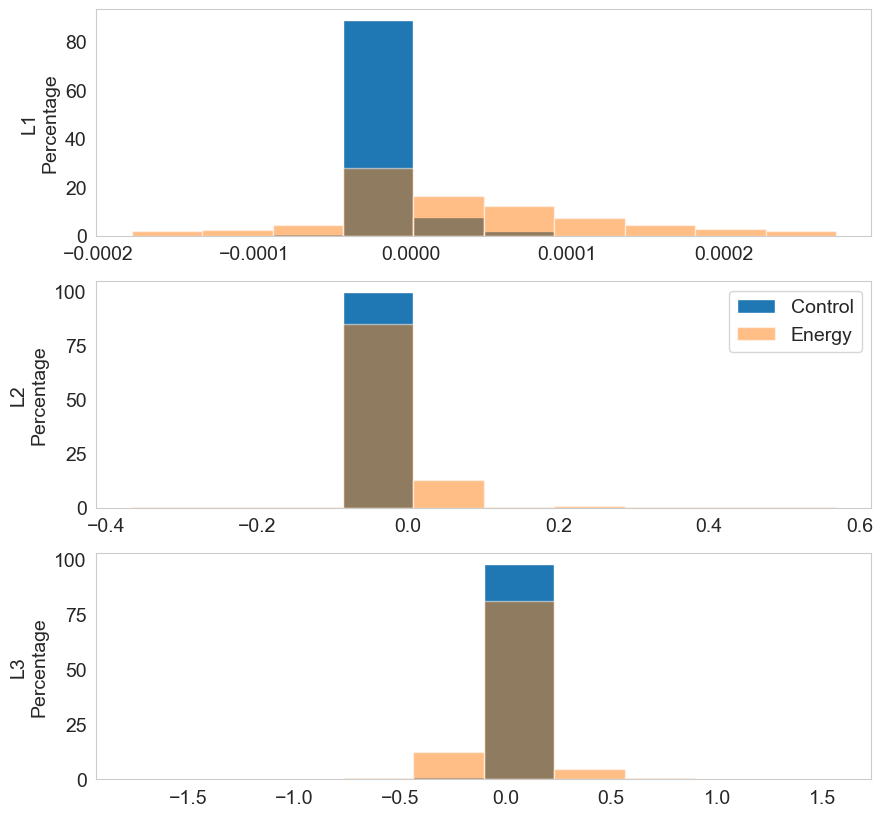

In [96]:
fig,ax=plt.subplots(3,1,figsize=(10, 10))
_,bins1,_ = ax[0].hist(l1_diff_control[0].flatten(),weights=[100/50/l1_diff_control[0].shape[1]]*50*l1_diff_control[0].shape[1],bins=10)
_,bins2,_ = ax[1].hist(l2_diff_control[0].flatten(),weights=[100/50/l2_diff_control[0].shape[1]]*50*l2_diff_control[0].shape[1],bins=10,label='Control')
_,bins3,_ = ax[2].hist(l3_diff_control[0].flatten(),weights=[100/50/l3_diff_control[0].shape[1]]*50*l3_diff_control[0].shape[1],bins=10)

ax[0].hist(l1_diff_energy[0].flatten(),weights=[100/50/l1_diff_energy[0].shape[1]]*50*l1_diff_energy[0].shape[1],bins=bins1,alpha=0.5)
ax[1].hist(l2_diff_energy[0].flatten(),weights=[100/50/l2_diff_energy[0].shape[1]]*50*l2_diff_energy[0].shape[1],bins=bins2,alpha=0.5,label='Energy')
ax[2].hist(l3_diff_energy[0].flatten(),weights=[100/50/l3_diff_energy[0].shape[1]]*50*l3_diff_energy[0].shape[1],bins=bins3,alpha=0.5)

ax[1].legend()

ax[0].xaxis.set_label_position('top') 
ax[0].xaxis.set_label_position('top') 

ax[0].set_ylabel('L1\nPercentage')
ax[1].set_ylabel('L2\nPercentage')
ax[2].set_ylabel('L3\nPercentage')

Text(0, 0.5, 'L3\nPercentage')

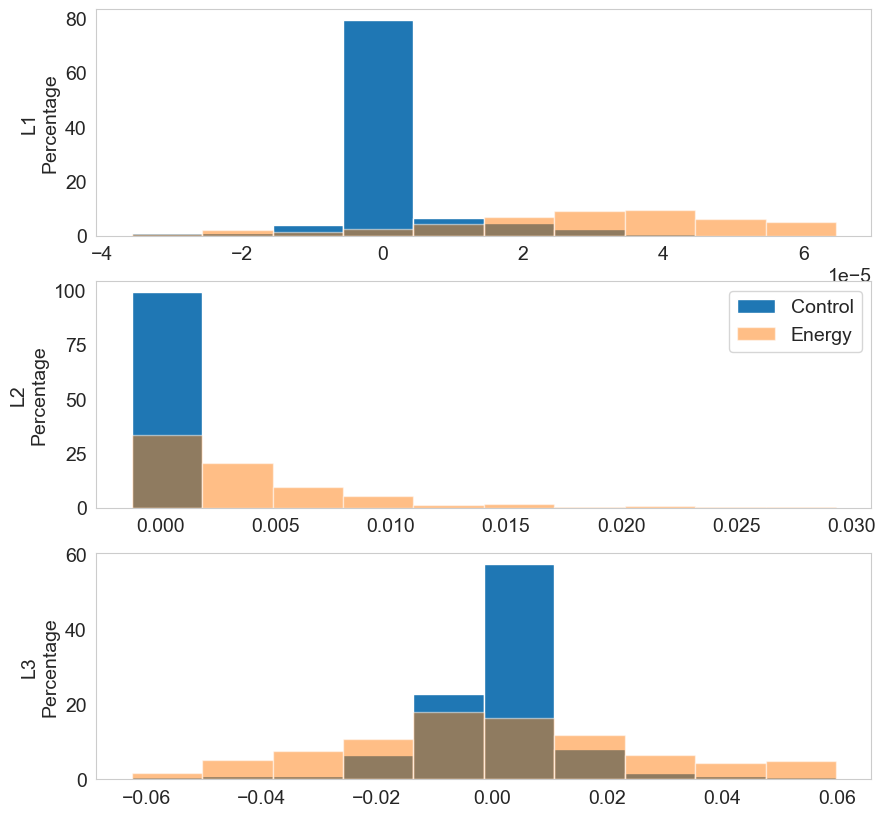

In [97]:
fig,ax=plt.subplots(3,1,figsize=(10, 10))
_,bins1,_ = ax[0].hist(l1_diff_control[0].mean(axis=0),weights=[100/l1_diff_control[0].shape[1]]*l1_diff_control[0].shape[1],bins=10)
_,bins2,_ = ax[1].hist(l2_diff_control[0].mean(axis=0),weights=[100/l2_diff_control[0].shape[1]]*l2_diff_control[0].shape[1],bins=10,label='Control')
_,bins3,_ = ax[2].hist(l3_diff_control[0].mean(axis=0),weights=[100/l3_diff_control[0].shape[1]]*l3_diff_control[0].shape[1],bins=10)

ax[0].hist(l1_diff_energy[0].mean(axis=0),weights=[100/l1_diff_energy[0].shape[1]]*l1_diff_energy[0].shape[1],bins=bins1,alpha=0.5)
ax[1].hist(l2_diff_energy[0].mean(axis=0),weights=[100/l2_diff_energy[0].shape[1]]*l2_diff_energy[0].shape[1],bins=bins2,alpha=0.5,label='Energy')
ax[2].hist(l3_diff_energy[0].mean(axis=0),weights=[100/l3_diff_energy[0].shape[1]]*l3_diff_energy[0].shape[1],bins=bins3,alpha=0.5)

ax[1].legend()

ax[0].xaxis.set_label_position('top') 
ax[0].xaxis.set_label_position('top') 

ax[0].set_ylabel('L1\nPercentage')
ax[1].set_ylabel('L2\nPercentage')
ax[2].set_ylabel('L3\nPercentage')

### Figure 3f: spikes

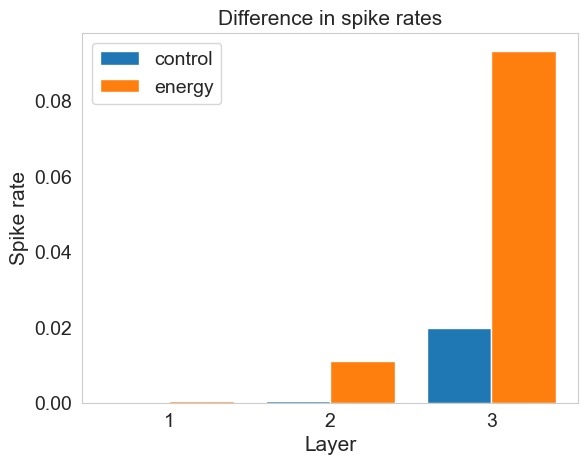

In [98]:
X_axis = np.arange(3)
plt.bar(X_axis-0.2,[np.abs(l1_diff_control[0]).mean(), np.abs(l2_diff_control[0]).mean(), np.abs(l3_diff_control[0]).mean()],0.4,label="control")
plt.bar(X_axis+0.2,[np.abs(l1_diff_energy[0]).mean(), np.abs(l2_diff_energy[0]).mean(), np.abs(l3_diff_energy[0]).mean()],0.4,label="energy")

labels=["1","2","3"]
plt.xticks(X_axis, labels) 
plt.xlabel("Layer",fontsize=15) 
plt.ylabel("Spike rate",fontsize=15) 
plt.title("Difference in spike rates",fontsize=15) 
plt.legend() 
plt.show() 

#### Figure 3g: voltage trajectories

Text(0.5, 1.0, 'MSD -0.07')

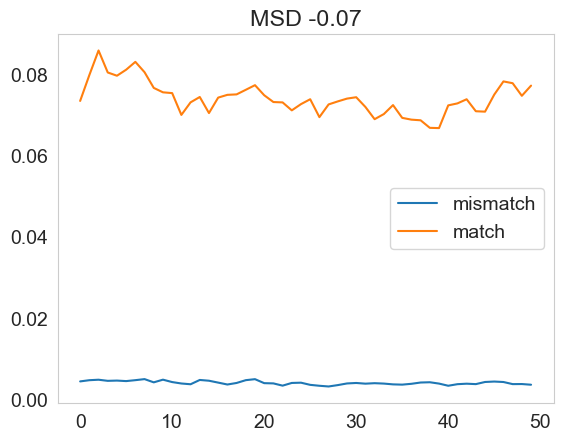

In [105]:
# Apical
idx = 1
plt.plot(l2_surprise_energy.mean(axis=0)[:,idx],label='mismatch')
plt.plot(l2_expected_energy.mean(axis=0)[:,idx],label='match')
plt.legend()
msd=(l2_surprise_energy.mean(axis=0)[:,idx]-l2_expected_energy.mean(axis=0)[:,idx]).mean().round(3)
plt.title('MSD {}'.format(msd))

Text(0.5, 1.0, 'MSD -0.097')

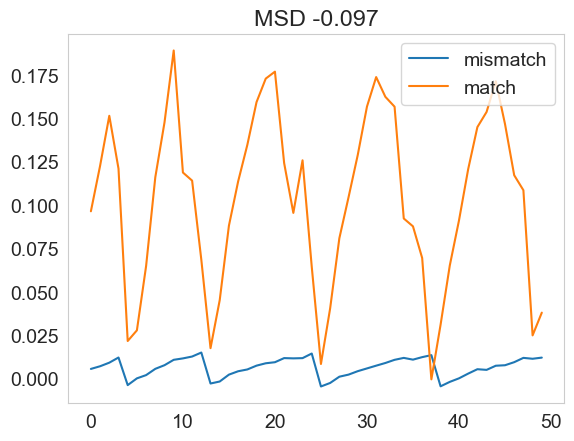

In [102]:
# Soma
idx = 1
plt.plot(l2_surprise_energy.mean(axis=0)[:,idx],label='mismatch')
plt.plot(l2_expected_energy.mean(axis=0)[:,idx],label='match')
plt.legend()
msd=(l2_surprise_energy.mean(axis=0)[:,idx]-l2_expected_energy.mean(axis=0)[:,idx]).mean().round(3)
plt.title('MSD {}'.format(msd))

# Add decorrelation term

## Train

In [ ]:
# network parameters
adap_neuron = True  # whether use adaptive neuron or not
clf_alpha = 1
energy_alpha = 0  # - config.clf_alpha
spike_alpha = 0.  # energy loss on spikes
num_readout = 10
onetoone = True
lr = 1e-3
alg = 'fptt'
dp = 0.4
is_rec = True


# training parameters
T = 100
K = 10  # k_updates is num updates per sequence
omega = int(T / K)  # update frequency
clip = 1.
log_interval = 20
epochs = 35



# set input and t param
IN_dim = 784
hidden_dim = [600, 500, 500]
n_classes = 10
torch.manual_seed(999)
# define network
model = SnnNetwork3Layer(IN_dim, hidden_dim, n_classes, is_adapt=adap_neuron,
                         one_to_one=onetoone, dp_rate=dp, is_rec=is_rec)
model.to(device)
print(model)

# define new loss and optimiser
total_params = count_parameters(model)
print('total param count %i' % total_params)

# define optimiser
optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay=0.0001)
# reduce the learning after 20 epochs by a factor of 10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)



named_params = get_stats_named_params(model)
all_test_losses = []
all_test_acc = []
best_acc1 = 20

# ADD ONE DECORR MATRIX FOR THE VERY BEGINNING OF THE NETWORK INPUT
decorr_matrix0 = torch.eye(IN_dim).to(device)
decorr_matrix1 = torch.eye(hidden_dim[0]).to(device)
decorr_matrix2 = torch.eye(hidden_dim[0]).to(device)
decorr_matrix3 = torch.eye(hidden_dim[1]).to(device)
decorr_matrix4 = torch.eye(hidden_dim[2]).to(device)

import time
start_time=time.time()

for epoch in range(epochs):
    decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4 = train_fptt_decorr(epoch, batch_size, log_interval, train_loader,
               model, named_params, T, K, omega, optimizer,
               clf_alpha, energy_alpha, spike_alpha, clip, lr, decorr_matrix0, decorr_matrix1, decorr_matrix2, decorr_matrix3, decorr_matrix4)

    reset_named_params(named_params)
    
    test_loss, acc1 = test_decorrelation(
        model, test_loader, T, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4)

    scheduler.step()

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)
    
    if is_best:
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            # 'oracle_state_dict': oracle.state_dict(),
            'best_acc1': best_acc1,
            'optimizer': optimizer.state_dict(),
            # 'oracle_optimizer' : oracle_optim.state_dict(),
        }, is_best, prefix='voltage_diff_', filename='best.pth.tar')

    all_test_losses.append(test_loss)
    all_test_acc.append(acc1)

    #if acc1>97:
    #    break

print("Runtime",time.time()-start)

In [26]:
named_params = get_stats_named_params(model)
named_params['layer1.tau_curr_decay']

(Parameter containing:
 tensor([3.2325e-12, 6.0917e-13, 5.5967e-13, 1.2354e-12, 2.1568e-13, 1.4623e-01,
         9.9247e-11, 4.5984e-01, 1.0167e-12, 1.0488e-11, 2.0109e-12, 5.6237e-13,
         1.9312e-07, 2.8903e-12, 5.0877e-12, 3.0215e-01, 4.2009e-12, 4.2120e-13,
         2.2639e-09, 2.9967e-12, 2.4060e-12, 1.7882e-01, 2.7348e-01, 4.0738e-01,
         5.0394e-12, 3.0764e-01, 2.5194e-01, 3.5703e-13, 1.5779e-12, 1.0061e-12,
         2.5537e-12, 1.4915e-12, 9.9633e-13, 6.9776e-13, 2.8959e-12, 6.5731e-13,
         2.2901e-10, 2.0291e-12, 1.4131e-12, 1.4312e-12, 1.5270e-12, 1.7090e-01,
         6.5397e-12, 1.1789e-12, 5.2931e-12, 9.6395e-13, 4.7038e-13, 8.8166e-13,
         6.5606e-12, 4.0234e-13, 4.4759e-13, 2.3881e-10, 2.2298e-13, 4.1189e-12,
         9.9131e-13, 9.8278e-13, 5.4090e-12, 1.0948e-12, 3.6202e-01, 2.6599e-01,
         6.9774e-13, 6.9029e-12, 1.0933e-12, 7.8226e-11, 2.9190e-12, 6.1759e-13,
         3.8428e-13, 3.0834e-01, 2.1156e-12, 3.8794e-01, 1.9480e-01, 1.1295e-12,
     

In [27]:
named_params = get_stats_named_params(model)
named_params['layer1.tau_m']

(Parameter containing:
 tensor([4.2605, 4.4219, 4.3712, 4.1618, 4.3006, 4.4386, 4.2070, 4.3521, 4.3409,
         4.3061, 4.3855, 4.3186, 4.1986, 4.1436, 4.3463, 4.1854, 4.3737, 4.2463,
         4.2122, 4.3101, 4.4094, 4.2676, 4.2204, 4.3736, 4.4087, 4.4856, 4.2937,
         4.2085, 4.2491, 4.3808, 4.1682, 4.3564, 4.1879, 4.1741, 4.2814, 4.2090,
         4.3226, 4.4617, 4.2421, 4.2160, 4.2848, 4.1969, 4.2228, 4.4276, 4.2629,
         4.1819, 4.2740, 4.2022, 4.3748, 4.3935, 4.3997, 4.2660, 4.3977, 4.4326,
         4.3165, 4.4641, 4.3787, 4.3874, 4.1806, 4.2703, 4.1645, 4.2734, 4.2697,
         4.0053, 4.2008, 4.3751, 4.1151, 4.0819, 4.4185, 4.3223, 4.3865, 4.3350,
         4.3191, 4.3260, 4.2322, 4.4336, 4.2369, 4.2272, 4.3520, 4.1462, 4.2033,
         4.2928, 4.3830, 4.2195, 4.3408, 4.4157, 4.3609, 4.3736, 4.3853, 4.1458,
         4.2254, 4.2290, 4.2713, 4.5033, 4.3060, 4.3048, 4.5473, 4.4074, 4.1736,
         4.3055, 4.5953, 4.2606, 4.3832, 4.2448, 4.4719, 4.3809, 4.4110, 4.4921,
     

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Test loss')

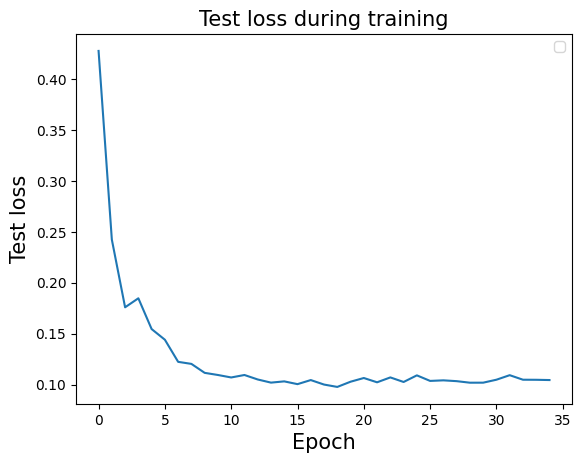

In [61]:
plt.plot(all_test_losses)
plt.legend()
plt.title('Test loss during training',fontsize=15)
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Test loss',fontsize=15)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Test error rate (%)')

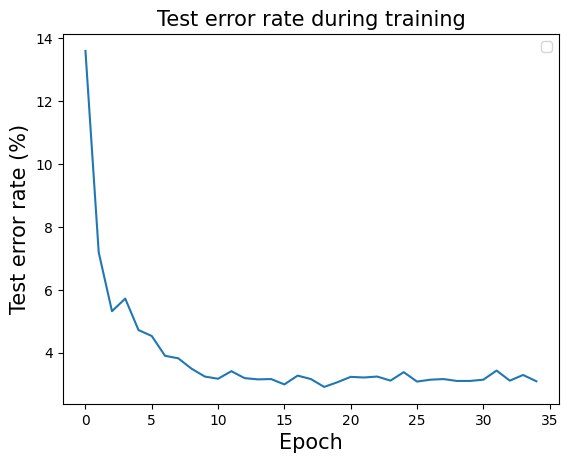

In [62]:
plt.plot(100*(10000-100*np.array(all_test_acc))/10000)
plt.legend()
plt.title('Test error rate during training',fontsize=15)
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Test error rate (%)',fontsize=15)

Text(0.5, 1.0, 'Layer 0 decorrelation matrix after 35 epochs')

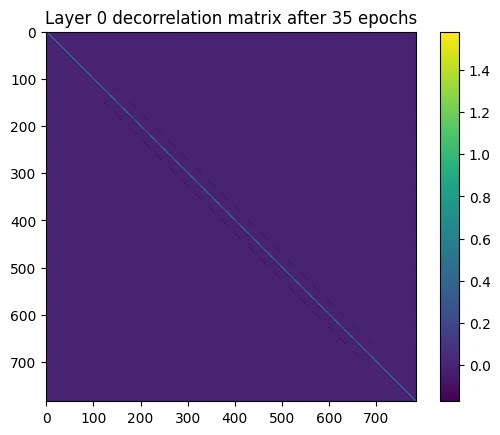

In [63]:
plt.imshow(decorr_matrix_0.cpu())
plt.colorbar()
plt.title('Layer 0 decorrelation matrix after 35 epochs')

Decorrelation of the input to each layer leads to worse network performance. At each timestep, the same input is multiplied by the decorrelation term,
but the decorrelation term is always changed after one timestep. Since the updates of the decorrelation term always involve a decrease compared to the previous term, this matrix gets smaller and smaller. As an effect, the input that is multiplied by this decorrelation matrix also gets smaller and smaller. TO visualize this effect, the below experiment repeats the multiplication of the input by the decorrelation term and the update of the decorrelation term for 100 iterations, and extracts the meand and std of the input after each iteration. It is clear than both the mean and std decrease drastically. This explains the poor network performance, since later on during the training, the inputs become so small that there is nothing to learn.

0 torch.Size([200, 1, 28, 28])


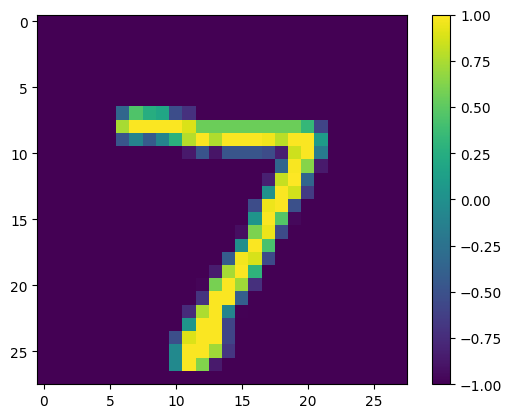

In [56]:
for idx, im in enumerate(test_loader):
    print(idx,im[0].shape)
    if idx==0:
        break

input = im[0][0][0]
plt.imshow(input)
plt.colorbar()
input=input.reshape(1,784)

In [57]:
means=[]
stds=[]
n=1e-3
for repeat in range(100):
    input = im[0][0][0]
    input=input.reshape(1,784)
    if repeat==0:
        decorr_matrix_prev_batch = decorr_matrix_0.cpu() #torch.eye(784)
    else:
        decorr_matrix_prev_batch = decorr_matrix_next 
    diag = torch.diag_embed(torch.square(input)) # (batch_size,hidden_dim,hidden_dim)
    input = input.reshape(input.shape[0],input.shape[1],1) # (batch_size,hidden_dim,1)
    input = torch.matmul(decorr_matrix_prev_batch, input) # (batch_size,hidden_dim,1)
    
    mult = torch.matmul(input, torch.transpose(input,1,2)) # (batch_size,hidden_dim,hidden_dim)
    update = torch.mean(mult - diag, dim=0) # (hidden_dim,hidden_dim)
    decorr_matrix_next = decorr_matrix_prev_batch - n * torch.matmul(update, decorr_matrix_prev_batch) # (hidden_dim,hidden_dim)
    input = input.reshape(input.shape[0],input.shape[1]) # (batch_size,hidden_dim)
    means.append(input.mean().numpy())
    stds.append(input.std().numpy())

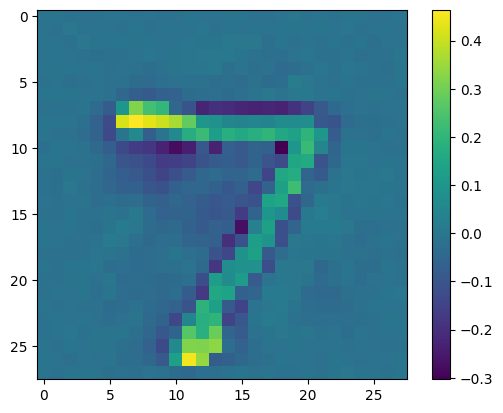

In [58]:
# after 100 passes, input looks like the original input, but its values are considerably reduced
plt.imshow(input.reshape(28,28))
plt.colorbar()

Text(0.5, 1.0, 'Evolution of mean and std of decorrelated input pixel values')

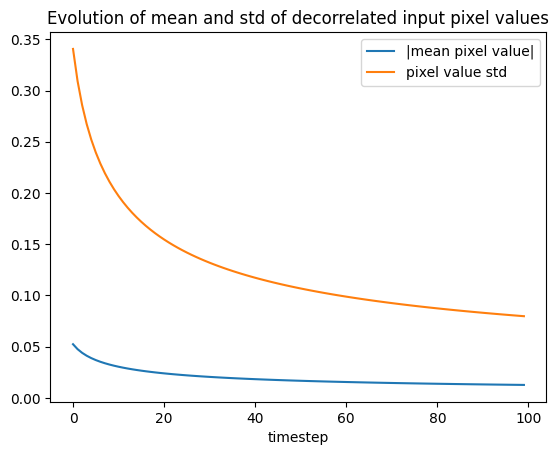

In [59]:
plt.plot(np.abs(means),label='|mean pixel value|')
plt.plot(stds,label='pixel value std')
plt.legend()
plt.xlabel('timestep')
plt.title('Evolution of mean and std of decorrelated input pixel values')

# Rise-time

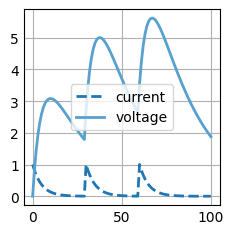

In [171]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

plt.style.use('_mpl-gallery')

# make data
x = np.linspace(0, 100, 101) #ms
current = np.linspace(0, 100, 101) #ms
voltage = np.linspace(0, 100, 101) #ms
ff = np.zeros(101)
# impulse current injection at times t= 0, 30 & 60
ff[0] = 1 
ff[30] = 1
ff[60] = 1

tau_r = 5 #rise time constant
tau_d = 25 #decay time constant

alpha = np.exp(-1/tau_r) 
beta= np.exp(-1/tau_d) 

i=0
current[0]=0
voltage[0]=0 

for xi in x:
    if(i==0):
        current[i] = ff[i]
    else:
        current[i] = alpha * current[i-1] + ff[i]        
        voltage[i] = beta*voltage[i-1]+current[i]
    i=i+1

# plot
plt.plot(x, current, linewidth=2.0, label='current', linestyle="--")
plt.plot(x, voltage, linewidth=2.0, label='voltage')
plt.legend()
# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),ylim=(0, 8), yticks=np.arange(1, 8))
plt.show()


